<a href="https://colab.research.google.com/github/surensnyper/ys_project_001/blob/main/2_Copy_of_Finetuned_Keras_QA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1.   video : https://www.youtube.com/watch?v=LuApA264Wbs&t=947s
2.   code : https://github.com/kimwoonggon/publicservant_AI/blob/master/(Uncased_Squad_V1_1)_%EC%BC%80%EB%9D%BC%EC%8A%A4%EB%A1%9C_Q%26A_%EA%B5%AC%ED%98%84%ED%95%98%EA%B8%B0.ipynb

In [ ]:
import os
import zipfile
import shutil

# BERT Model Download
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip

# bert folder construction in the Colab
if "bert" not in os.listdir():
  os.makedirs("bert")
else:
  pass

--2022-01-30 23:24:10--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.203.128, 74.125.197.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip.1’

uncased_L-12_H-768_ 100%[===================>] 388.84M   307MB/s    in 1.3s    

2022-01-30 23:24:12 (307 MB/s) - ‘uncased_L-12_H-768_A-12.zip.1’ saved [407727028/407727028]



In [ ]:
# Unzip the Model zip file in the bert folder
bert_zip  = zipfile.ZipFile('uncased_L-12_H-768_A-12.zip')
bert_zip.extractall('bert')

bert_zip.close()

In [ ]:
# Functoin Construction for copying the folder
def copytree(src, dst, symlinks=False, ignore=None):
  for item in os.listdir(src):
    s = os.path.join(src, item)
    d = os.path.join(dst, item)
    if os.path.isdir(s):
      shutil.copytrees(s, d, symlinks, ignore)
    else:
      shutil.copy2(s, d)

In [ ]:
# The unzipped folder is "bert/uncased_L-12_H-768_A-12", but copying & moving the model to the bert folder for easier analysis
copytree("bert/uncased_L-12_H-768_A-12", "bert")

In [ ]:
# SQuAD v1.1 dataset download for training (train-v1.1) and validation (dev-v1.1)
!wget https://raw.githubusercontent.com/nate-parrott/squad/master/data/train-v1.1.json
!wget https://raw.githubusercontent.com/nate-parrott/squad/master/data/dev-v1.1.json

--2022-01-30 19:07:08--  https://raw.githubusercontent.com/nate-parrott/squad/master/data/train-v1.1.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30288272 (29M) [text/plain]
Saving to: ‘train-v1.1.json’

train-v1.1.json     100%[===================>]  28.88M  --.-KB/s    in 0.1s    

2022-01-30 19:07:09 (243 MB/s) - ‘train-v1.1.json’ saved [30288272/30288272]

--2022-01-30 19:07:09--  https://raw.githubusercontent.com/nate-parrott/squad/master/data/dev-v1.1.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4854279 (4.6M

In [ ]:
# Google drive and Colab Connecting
import os
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Required modules are imported, e.g. Tensorflow, Pandas, Numpy, Keras etc
import tensorflow as tf
import pandas as pd
import numpy as np
import re
import pickle

import keras as keras
from keras.models import load_model
from keras import backend as K
from keras import Input, Model
from keras import optimizers
from keras.layers import Layer

import codecs
from tqdm import tqdm
import shutil
import json

In [ ]:
# To make various logs nor popped up
import warnings
warnings.filterwarnings(action='ignore')
os.environ['TF_CPP_WIN_LOG_LEVEL']='3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) # Version updated (tensorflow logging tf.logging -> tf.compat.v1.logging)

In [ ]:
# A module 'keras-bert' install, for using bert easily in keras
!pip install keras-bert

  Created wheel for keras-bert: filename=keras_bert-0.89.0-py3-none-any.whl size=33517 sha256=e97066c329fd7c04f8576a1a8cedb1ac5ef04a926b3ca9a4a070e242e905244b
  Stored in directory: /root/.cache/pip/wheels/a4/e8/45/842b3a39831261aef9154b907eacbc4ac99499a99ae829b06f
  Created wheel for keras-transformer: filename=keras_transformer-0.40.0-py3-none-any.whl size=12305 sha256=31366ef64c4ed86944b62022c182468b9196a7c0ba85c232e913f63188691674
  Stored in directory: /root/.cache/pip/wheels/46/68/26/692ed21edd832833c3b0a0e21615bcacd99ca458b3f9ed571f
  Created wheel for keras-embed-sim: filename=keras_embed_sim-0.10.0-py3-none-any.whl size=3960 sha256=d17a235810ca82b66ed5f3e0169b0ee6abdd6d85ef5d8fc94b982ae7473970c4
  Stored in directory: /root/.cache/pip/wheels/81/67/b5/d847588d075895281e1cf5590f819bd4cf076a554872268bd5
  Created wheel for keras-layer-normalization: filename=keras_layer_normalization-0.16.0-py3-none-any.whl size=4668 sha256=8203e2352d647fda8ae2b56e9f6811a89d4bd82a9f32c6d988cf9258

In [ ]:
# An optimizer 'keras-radam' import, which is an updated optimizer of 'Adam'
# 'radam' is to update learning rate from 0 to target value 'gradually', so training session is more stable
!pip install keras-radam

  Created wheel for keras-radam: filename=keras_radam-0.15.0-py3-none-any.whl size=14686 sha256=ab82104b47ddaa6a39ad25f10c4ab4f1f6636f6a40179dbbc6c89a11fec3b639
  Stored in directory: /root/.cache/pip/wheels/23/6a/5f/d674f3b7b4d504b03148abd675e3703ba00c31763c04a2fc20
Successfully built keras-radam


In [ ]:
# Other libraries for using bert model in the keras-bert libraries
from keras_bert import load_trained_model_from_checkpoint, load_vocabulary
from keras_bert import Tokenizer
from keras_bert import AdamWarmup, calc_train_steps

from keras_radam.training import RAdamOptimizer # Original RAdam changed to RAdamOptimizer
# from keras_radam import RAdam
# https://github.com/CyberZHG/keras-radam (KERAS-RADAM)

In [ ]:
# It is easy to use Pandas data framework in Python, so
# converting SQuAD json file into Pandas format by a function

def squad_json_to_dataframe_train(input_file_path, record_path = ['data','paragraphs','qas','answers'],
                           verbose = 1):
    """
    input_file_path: path to the squad json file.
    record_path: path to deepest level in json file default value is
    ['data','paragraphs','qas','answers']
    verbose: 0 to suppress it default is 1
    """
    if verbose:
        print("Reading the json file")    
    file = json.loads(open(input_file_path).read())
    if verbose:
        print("processing...")
    # parsing different level's in the json file
    js = pd.io.json.json_normalize(file , record_path )
    m = pd.io.json.json_normalize(file, record_path[:-1] )
    r = pd.io.json.json_normalize(file,record_path[:-2])
    
    #combining it into single dataframe
    idx = np.repeat(r['context'].values, r.qas.str.len())
    ndx  = np.repeat(m['id'].values,m['answers'].str.len())
    m['context'] = idx
    js['q_idx'] = ndx
    main = pd.concat([ m[['id','question','context']].set_index('id'),js.set_index('q_idx')],1,sort=False).reset_index()
    main['c_id'] = main['context'].factorize()[0]
    if verbose:
        print("shape of the dataframe is {}".format(main.shape))
        print("Done")
    return main

In [ ]:
# SQuAD dataset loading in Pandas format
train = squad_json_to_dataframe_train("train-v1.1.json")

Reading the json file
processing...
shape of the dataframe is (87599, 6)
Done


In [ ]:
train

,index,question,context,answer_start,text,c_id
0,5733be284776f41900661182,To whom did the Virgin Mary allegedly appear i...,"Architecturally, the school has a Catholic cha...",515,Saint Bernadette Soubirous,0
1,5733be284776f4190066117f,What is in front of the Notre Dame Main Building?,"Architecturally, the school has a Catholic cha...",188,a copper statue of Christ,0
2,5733be284776f41900661180,The Basilica of the Sacred heart at Notre Dame...,"Architecturally, the school has a Catholic cha...",279,the Main Building,0
3,5733be284776f41900661181,What is the Grotto at Notre Dame?,"Architecturally, the school has a Catholic cha...",381,a Marian place of prayer and reflection,0
4,5733be284776f4190066117e,What sits on top of the Main Building at Notre...,"Architecturally, the school has a Catholic cha...",92,a golden statue of the Virgin Mary,0
...,...,...,...,...,...,...
87594,5735d259012e2f140011a09d,In what US state did Kathmandu first establish...,"Kathmandu Metropolitan City (KMC), in order to...",229,Oregon,18890
87595,5735d259012e2f140011a09e,What was Yangon previously known as?,"Kathmandu Metropolitan City (KMC), in order to...",414,Rangoon,18890
87596,5735d259012e2f140011a09f,With what Belorussian city does Kathmandu have...,"Kathmandu Metropolitan City (KMC), in order to...",476,Minsk,18890
87597,5735d259012e2f140011a0a0,In what year did Kathmandu create its initial ...,"Kathmandu Metropolitan City (KMC), in order to...",199,1975,18890


In [ ]:
# Deletig the questions having lenth less than 10
train = train.loc[train['question'].str.len()>=10].reset_index(drop=True)

In [ ]:
# Hyperparameters set up

# Input sequence maximum length setup (Question + Context)
SEQ_LEN = 384

# Batch size (training size at one time)
BATCH_SIZE = 12

EPOCH = 2

# Learning rate is set in very small number like 1.5e-5.
# In fine tuning session, Learning rate must be very small 
# (Optimizer RAdam starts from LR 0 to 1.5e-5)
LR = 1.5e-5

# Model location designation
pretrained_path = "bert"
# Pretrained hyperparameters like weights
checkpoint_path = os.path.join(pretrained_path, 'bert_model.ckpt')
# Word corpus file location designation
vocab_path =  os.path.join(pretrained_path, 'vocab.txt')

# Configuration file designation
config_path = os.path.join(pretrained_path, 'bert_config.json')

# Column name of context
DATA_COLUMN = "context"
# Column name of question
QUESTION_COLUMN = "question"
# Column name of answer ('text')
TEXT = "text"

In [ ]:
# Dictionary Construction for indexing each word
token_dict = {}
with codecs.open(vocab_path, 'r', 'utf8') as reader:
  for line in reader:
    token = line.strip()
    token_dict[token] = len(token_dict)

In [ ]:
token_dict

{'[PAD]': 0,
 '[unused0]': 1,
 '[unused1]': 2,
 '[unused2]': 3,
 '[unused3]': 4,
 '[unused4]': 5,
 '[unused5]': 6,
 '[unused6]': 7,
 '[unused7]': 8,
 '[unused8]': 9,
 '[unused9]': 10,
 '[unused10]': 11,
 '[unused11]': 12,
 '[unused12]': 13,
 '[unused13]': 14,
 '[unused14]': 15,
 '[unused15]': 16,
 '[unused16]': 17,
 '[unused17]': 18,
 '[unused18]': 19,
 '[unused19]': 20,
 '[unused20]': 21,
 '[unused21]': 22,
 '[unused22]': 23,
 '[unused23]': 24,
 '[unused24]': 25,
 '[unused25]': 26,
 '[unused26]': 27,
 '[unused27]': 28,
 '[unused28]': 29,
 '[unused29]': 30,
 '[unused30]': 31,
 '[unused31]': 32,
 '[unused32]': 33,
 '[unused33]': 34,
 '[unused34]': 35,
 '[unused35]': 36,
 '[unused36]': 37,
 '[unused37]': 38,
 '[unused38]': 39,
 '[unused39]': 40,
 '[unused40]': 41,
 '[unused41]': 42,
 '[unused42]': 43,
 '[unused43]': 44,
 '[unused44]': 45,
 '[unused45]': 46,
 '[unused46]': 47,
 '[unused47]': 48,
 '[unused48]': 49,
 '[unused49]': 50,
 '[unused50]': 51,
 '[unused51]': 52,
 '[unused52]': 53,

In [ ]:
# Tokenizer Construction
tokenizer = Tokenizer(token_dict)

In [ ]:
# Checking if the tokenizer works well
print(tokenizer.tokenize("Keras is really fun."))
print(tokenizer.tokenize("We can manipulate AI."))

['[CLS]', 'ke', '##ras', 'is', 'really', 'fun', '.', '[SEP]']
['[CLS]', 'we', 'can', 'manipulate', 'ai', '.', '[SEP]']


In [ ]:
# For later use, updated dictionary constructed (number - word order)
reverse_token_dict = {v : k for k, v in token_dict.items()}

In [ ]:
reverse_token_dict

{0: '[PAD]',
 1: '[unused0]',
 2: '[unused1]',
 3: '[unused2]',
 4: '[unused3]',
 5: '[unused4]',
 6: '[unused5]',
 7: '[unused6]',
 8: '[unused7]',
 9: '[unused8]',
 10: '[unused9]',
 11: '[unused10]',
 12: '[unused11]',
 13: '[unused12]',
 14: '[unused13]',
 15: '[unused14]',
 16: '[unused15]',
 17: '[unused16]',
 18: '[unused17]',
 19: '[unused18]',
 20: '[unused19]',
 21: '[unused20]',
 22: '[unused21]',
 23: '[unused22]',
 24: '[unused23]',
 25: '[unused24]',
 26: '[unused25]',
 27: '[unused26]',
 28: '[unused27]',
 29: '[unused28]',
 30: '[unused29]',
 31: '[unused30]',
 32: '[unused31]',
 33: '[unused32]',
 34: '[unused33]',
 35: '[unused34]',
 36: '[unused35]',
 37: '[unused36]',
 38: '[unused37]',
 39: '[unused38]',
 40: '[unused39]',
 41: '[unused40]',
 42: '[unused41]',
 43: '[unused42]',
 44: '[unused43]',
 45: '[unused44]',
 46: '[unused45]',
 47: '[unused46]',
 48: '[unused47]',
 49: '[unused48]',
 50: '[unused49]',
 51: '[unused50]',
 52: '[unused51]',
 53: '[unused52]',

In [ ]:
# Checking if the tokenizer works well again in QnA format ([CLS} Question [SEP] Context [SEP] order)
print(tokenizer.tokenize("Where does Youngsun live in now?", "My name is Youngsun Jang, and I live in US now."))

['[CLS]', 'where', 'does', 'young', '##sun', 'live', 'in', 'now', '?', '[SEP]', 'my', 'name', 'is', 'young', '##sun', 'jang', ',', 'and', 'i', 'live', 'in', 'us', 'now', '.', '[SEP]']


In [ ]:
# Word Embedding (Numberical representation)
print(tokenizer.encode("Where does Youngsun live in now?", "My name is Youngsun Jang, and I live in US now."))

([101, 2073, 2515, 2402, 19729, 2444, 1999, 2085, 1029, 102, 2026, 2171, 2003, 2402, 19729, 23769, 1010, 1998, 1045, 2444, 1999, 2149, 2085, 1012, 102], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


In [ ]:
train.head(5)

,index,question,context,answer_start,text,c_id
0,5733be284776f41900661182,To whom did the Virgin Mary allegedly appear i...,"Architecturally, the school has a Catholic cha...",515,Saint Bernadette Soubirous,0
1,5733be284776f4190066117f,What is in front of the Notre Dame Main Building?,"Architecturally, the school has a Catholic cha...",188,a copper statue of Christ,0
2,5733be284776f41900661180,The Basilica of the Sacred heart at Notre Dame...,"Architecturally, the school has a Catholic cha...",279,the Main Building,0
3,5733be284776f41900661181,What is the Grotto at Notre Dame?,"Architecturally, the school has a Catholic cha...",381,a Marian place of prayer and reflection,0
4,5733be284776f4190066117e,What sits on top of the Main Building at Notre...,"Architecturally, the school has a Catholic cha...",92,a golden statue of the Virgin Mary,0


In [ ]:
print("Question: ", train.loc[0, 'question'])
print("Context: ", train.loc[0, 'context'])
print("Answer: ", train.loc[0, 'text'])

Question:  To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
Context:  Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.
Answer:  Saint Bernadette Soubirous


In [ ]:
# QA is to confirm the position of the Answer token in Context 
# position of Saint Bernadette Soubirous !
# That is, from 3002 - 2271

print("Question: ", tokenizer.tokenize(train.loc[0, 'question']))
print("Context: ", tokenizer.tokenize(train.loc[0, 'context']))
print("Answer: ", tokenizer.tokenize(train.loc[0, 'text']))

print("Question: ", tokenizer.encode(train.loc[0, 'question']))
print("Context: ", tokenizer.encode(train.loc[0, 'context']))
print("Answer: ", tokenizer.encode(train.loc[0, 'text']))

Question:  ['[CLS]', 'to', 'whom', 'did', 'the', 'virgin', 'mary', 'allegedly', 'appear', 'in', '1858', 'in', 'lou', '##rdes', 'france', '?', '[SEP]']
Context:  ['[CLS]', 'architectural', '##ly', ',', 'the', 'school', 'has', 'a', 'catholic', 'character', '.', 'atop', 'the', 'main', 'building', "'", 's', 'gold', 'dome', 'is', 'a', 'golden', 'statue', 'of', 'the', 'virgin', 'mary', '.', 'immediately', 'in', 'front', 'of', 'the', 'main', 'building', 'and', 'facing', 'it', ',', 'is', 'a', 'copper', 'statue', 'of', 'christ', 'with', 'arms', 'up', '##rai', '##sed', 'with', 'the', 'legend', '"', 've', '##ni', '##te', 'ad', 'me', 'om', '##nes', '"', '.', 'next', 'to', 'the', 'main', 'building', 'is', 'the', 'basilica', 'of', 'the', 'sacred', 'heart', '.', 'immediately', 'behind', 'the', 'basilica', 'is', 'the', 'gr', '##otto', ',', 'a', 'marian', 'place', 'of', 'prayer', 'and', 'reflection', '.', 'it', 'is', 'a', 'replica', 'of', 'the', 'gr', '##otto', 'at', 'lou', '##rdes', ',', 'france', 'wh

In [ ]:
# Getting only token part excepting the segment part
context = tokenizer.encode(train.loc[0, 'context'])[0]
text = tokenizer.encode(train.loc[0, 'text'])[0]

In [ ]:
# CLS, SEP token delete
text.pop(0)
text.pop(-1)
print(text)
print(len(text))
len(context)

[3002, 16595, 9648, 4674, 2061, 12083, 9711, 2271]
8


160

In [ ]:
# To calculate the length of text (answer)
# Method : Doing 'Sliding' the context with the length of the answer
text_slide_len = len(text) # text_slide_len = 8

for j in range(0, (len(context))):
  # exist_flag : showing whether it is answerable or not (similar with is_unanswerable in SimpleTransforemr)
  # 0 : No answer / 1 : Having answer
  exist_flag = 0 
  if text == context[j:j+text_slide_len]: # [0:8]->[1:9]->[2:10]->..->[159:160]
    # Assign the location of answer (start, end)
    ans_start = j
    ans_end = j + text_slide_len - 1
    # If matched, exist_flag changed to 1
    exist_flag = 1
    break

print("ans_start : {}, ans_end : {}".format(ans_start, ans_end))


ans_start : 114, ans_end : 121


In [ ]:
# Check
# context[ans_start:ans_end]
print(context[ans_start:ans_end+1], text)

[3002, 16595, 9648, 4674, 2061, 12083, 9711, 2271] [3002, 16595, 9648, 4674, 2061, 12083, 9711, 2271]


In [ ]:
# Define a function calculating the length of answer in context dataset all at once
def convert_data(data_df):
  global tokenizer
  indices, segments, target_start, target_end = [], [], [], []

  for i in tqdm(range(len(data_df))):
    # que : List of tokenized question
    que, _ = tokenizer.encode(data_df[QUESTION_COLUMN][i])
    # doc : List of tokenized context
    doc, _ = tokenizer.encode(data_df[DATA_COLUMN][i])

    # [CLS] token deleted in context
    doc.pop(0)

    # Length of question & context
    que_len = len(que)
    doc_len = len(doc)
    # 1. Length of question
    # The question is cut by the length of 64
    if que_len > 64:
      que = que[:63]
      que.append(102) # [SEP] token added to make it clear the question block
    # 2. Total length of question and context
    # The total input is cut by the length of 384
    if len(que+doc) > SEQ_LEN:
      while len(que+doc) != SEQ_LEN:
        doc.pop(-1)
      doc.pop(-1)
      doc.append(102)

    # Segment embedding
    # Question : 0 / Context 1 / Padding : 0 (remaining part for short sentences)
        
    ############################
    ###### Segment 예시 ########
    ############################
    
    # question, context, padding
    # 00000000, 1111111, 0000000
    
    segment = [0]*len(que) + [1]*len(doc) + [0]*(SEQ_LEN-len(que)-len(doc))

    # Padding
    if len(que+doc) <= SEQ_LEN:
      while len(que+doc) != SEQ_LEN:
        doc.append(0)

    # Final Input 'ids' (Question + Context)
    ids = que + doc

    # Sliding Part
    text = tokenizer.encode(data_df[TEXT][i])[0]
    text_slide_len = len(text[1:-1]) # text_slide_len = 8

    for j in range(0, (len(doc))):
      # exist_flag : showing whether it is answerable or not (similar with is_unanswerable in SimpleTransforemr)
      # 0 : No answer / 1 : Having answer
      exist_flag = 0 
      if text[1:-1] == doc[j:j+text_slide_len]: # [0:8]->[1:9]->[2:10]->..->[159:160]
        # Assign the location of answer (start, end)
        ans_start = j + len(que)
        ans_end = j + text_slide_len - 1 + len(que)
        # If matched, exist_flag changed to 1
        exist_flag = 1
        break

    # When no answer case (exist_flag = 0), starting & ending value become SEQ_LEN
    # All the data of starting, ending = 384 (SEQ_LEN) will be deleted from the list
    if exist_flag == 0:
      ans_start = SEQ_LEN
      ans_end = SEQ_LEN

    # Input(ids), Segment saving into list type (indices, segments)
    indices.append(ids)
    segments.append(segment)
    # Starting and ending info saving into list type (target_start, target_end)
    target_start.append(ans_start)
    target_end.append(ans_end)

  # Converting the 4 lists into numpy array
  indices_x = np.array(indices)
  segments = np.array(segments)
  target_start = np.array(target_start)
  target_end = np.array(target_end)

  # The cut part saved in del_list and deleted from data
  del_list = np.where(target_start != SEQ_LEN)[0]
  not_del_list = np.where(target_start == SEQ_LEN)[0]
  indices_x = indices_x[del_list]
  segments = segments[del_list]
  target_start = target_start[del_list]
  target_end = target_end[del_list]

  return [indices_x, segments], [target_start, target_end], not_del_list

In [ ]:
# Load of the Calculator Function
def load_data(pandas_dataframe):
  data_df = pandas_dataframe
  data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)
  data_df[QUESTION_COLUMN] = data_df[QUESTION_COLUMN].astype(str)
  data_x, data_y, del_list = convert_data(data_df)

  return data_x, data_y, del_list

In [ ]:
# Train Data Coneversion Starting
train_x, train_y, z = load_data(train)

100%|██████████| 87589/87589 [03:18<00:00, 442.00it/s]


In [ ]:
print(train_x[0].shape, train_y[0].shape)

(87353, 384) (87353,)


In [ ]:
z

array([  366,   451,   453,   455,   460,   477,   672,   677,  1315,
        1590,  1595,  1600,  1922,  2360,  2361,  2478,  2491,  2683,
        2862,  3017,  3019,  3117,  3142,  3275,  3276,  3427,  3490,
        4312,  4786,  5121,  5919,  5924,  5928,  5932,  5990,  5992,
        5994,  5995,  6155,  6158,  6248,  6296,  6311,  6314,  6316,
        6329,  6330,  6354,  6392,  6985,  7096,  7331,  7528,  7529,
        7622,  7625,  7626,  7676,  7678,  7948,  8017,  8021,  8273,
        8735,  8835,  9741, 10000, 10578, 10653, 10675, 10699, 10700,
       11308, 11780, 11846, 11987, 12136, 12147, 12189, 12777, 12874,
       12969, 13470, 13692, 13702, 13729, 13783, 13787, 13791, 13799,
       13863, 14260, 14317, 14377, 14404, 14434, 14448, 14571, 14582,
       14600, 16070, 16116, 17168, 17344, 17410, 18100, 18369, 18707,
       19350, 19374, 19830, 20249, 20459, 20508, 20661, 22422, 23848,
       25521, 25931, 26648, 27627, 27687, 27972, 28010, 28246, 28420,
       28589, 29872,

In [ ]:
# Load the Pretrained Model
model = load_trained_model_from_checkpoint (
    config_path,
    checkpoint_path,
    training = False,
    trainable = True,
    seq_len = SEQ_LEN
)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input-Token (InputLayer)       [(None, 384)]        0           []                               
                                                                                                  
 Input-Segment (InputLayer)     [(None, 384)]        0           []                               
                                                                                                  
 Embedding-Token (TokenEmbeddin  [(None, 384, 768),  23440896    ['Input-Token[0][0]']            
 g)                              (30522, 768)]                                                    
                                                                                                  
 Embedding-Segment (Embedding)  (None, 384, 768)     1536        ['Input-Segment[0][0]']    

In [ ]:
# For Transfer Learning, Customized Layer needs to be added after 12 Encoder
# by defining 'Non-masking' function, BERT Model's masked tensors disclosed

class NonMasking(Layer):
  def __init__(self, **kwargs):
    self.supports_masking = True
    super(NonMasking, self).__init__(**kwargs)

  def build(self, input_shape):
    input_shape = input_shape
  
  def compute_mask(self, input, input_mask = None):
    return None

  def call(self, x, mask = None):
    return x

  def get_output_shape_for(self, input_shape):
    return input_shape

In [ ]:
# Activation function definition
def bert_gelu(x):
  """Gaussian Error Linear Unit.
  This is a smoother version of the RELU.
  Original paper: https://arxiv.org/abs/1606.08415
  Args:
    x : float Tensor to perform activation
  Returns:
    'x' with the GELU activation applied.
  """
  cdf = 0.5*(1.0+ K.tanh(
      (np.sqrt(2/np.pi)*(x+0.044715 * K.pow(x,3)))))
  return x*cdf

In [ ]:
# Activation Function Layer attached to Transformer
class Start_End_Prediction(Layer):
  def __init__(self, seq_len, **kwargs):
    self.seq_len = SEQ_LEN
    self.supports_masking = True
    super(Start_End_Prediction, self).__init__(**kwargs)

  def build(self, input_shape):
    # A tensor ('self.W') multiplied with the final layer (12 encoder, batch_size, 384, 768)
    # Making Output tensor as (384, 2 dimension (768->2))
    self.W = self.add_weight(name='kernel',
                             shape = (input_shape[2],2),
                             initializer = 'uniform',
                             trainable = True)
    super(Start_End_Prediction, self).build(input_shape)

  def call(self, x):
    # Redifine Output dimension as (384 * 768)
    x = K.reshape(x, shape=(-1, self.seq_len, K.shape(x)[2]))
    # Dot production between self.W and x
    # (batch_size, 384, 768) * (384, 2) = (batch_size, 384, 2)
    x = K.dot(x, self.W)
    # (batch_size, 384, 2) -> (2, batch_size, 384)
    x = K.permute_dimensions(x, (2, 0, 1))

    # Split the (2, batch_size, 384) into 2 (batch_size, 384)  --> start_logits & end_logits
    # start_logits = (batch_size, 384)
    # end_logits = (batch_size, 384)
    self.start_logits, self.end_logits = x[0], x[1]

    # Fed into, Passed by the GELU layer
    self.start_logits = bert_gelu(self.start_logits)
    self.end_logits = bert_gelu(self.end_logits)

    # Fed into, Passed by the Softmax layer
    # Getting probability for 384 tokens
    self.start_logits = K.softmax(self.start_logits, axis=-1)
    self.end_logits = K.softmax(self.end_logits, axis=-1)

    return [self.start_logits, self.end_logits]

  def compute_output_shape(self, input_shape):
    # In Keras, when defining custom layer, 
    # the output dimension must be defined in compute_output_shape function
    return [(input_shape[0], self.seq_len), (input_shape[0], self.seq_len)]

In [ ]:
# Load BERT model
from keras.layers import merge, dot, concatenate
from keras import metrics
import numpy as np

# Define a functoin loading BERT model
def get_bert_finetuning_model(model):
  # Input data is token-embedding and segment-embedding
  inputs = model.inputs[:2]

  # Output of Transformer : (batch_size, 384, 768)
  bert_transformer = model.layers[-1].output

  # Unmask the maksed tensors using NonMasking function
  x = NonMasking()(bert_transformer)

  # Show the start and end token of answer at last
  outputs_start, outputs_end = Start_End_Prediction(SEQ_LEN)(x)

  bert_model = keras.models.Model(inputs, [outputs_start, outputs_end])

  # Optimizer defined growing Learning_rate from 0 to 1.5e-5 gradually
  # Original RAdam changed to RAdamOptimizer for some issue
  optimizer_warmup = RAdamOptimizer(learning_rate = 1.5e-5, warmup_proportion=0.2, epsilon=1e-6, weight_decay = 0.01)

  # Final Model compile
  bert_model.compile(
      optimizer = optimizer_warmup,
      loss = 'sparse_categorical_crossentropy',
      metrics = ['accuracy']
  )

  return bert_model

In [ ]:
# Display format customize in wrap for Google Colab (Youngsun)
from IPython.display import HTML, display
def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

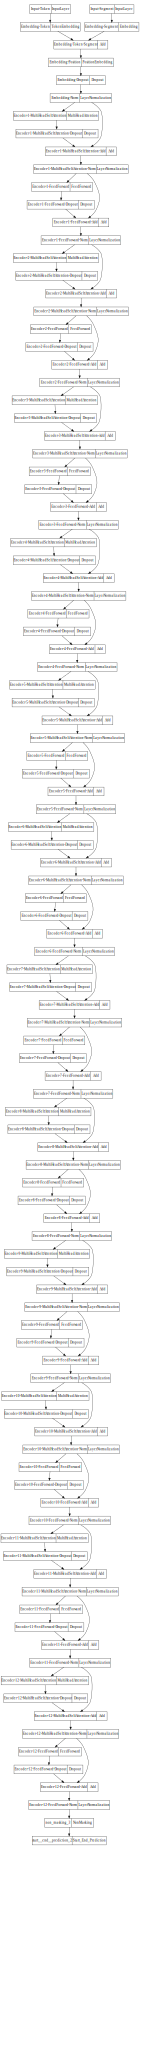

In [ ]:
# Model FLow Check
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(get_bert_finetuning_model(model), dpi=65).create(prog='dot', format='svg'))

In [ ]:
# GPU check
!nvidia-smi

Thu Jan 20 04:06:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    37W / 250W |   1401MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Training -- Error
# sess = K.get_session()
# uninitialized_variables = set([i.decode('ascii') for i in sess.run(tf.report_uninitialized_variables())])
# init = tf.variables_initializer([v for v in tf.global_variables() if v.name.split(':')[0] in uninitialized_variables])
# sess.run(init)

bert_model = get_bert_finetuning_model(model)
bert_model.summary()

# Training Start!
history = bert_model.fit(train_x, train_y, batch_size=12, shuffle=True, verbose=1, epochs=2)

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input-Token (InputLayer)       [(None, 384)]        0           []                               
                                                                                                  
 Input-Segment (InputLayer)     [(None, 384)]        0           []                               
                                                                                                  
 Embedding-Token (TokenEmbeddin  [(None, 384, 768),  23440896    ['Input-Token[0][0]']            
 g)                              (30522, 768)]                                                    
                                                                                                  
 Embedding-Segment (Embedding)  (None, 384, 768)     1536        ['Input-Segment[0][0]']    

In [ ]:
# It shows accuracy about 76% in the above
# Now need to get f1 score as alternative

from sklearn.metrics import classification_report
preds = bert_model.predict(train_x)

NameError: ignored

In [ ]:
start_indexes = np.argmax(preds[0], axis=-1)
end_indexes = np.argmax(preds[1], axis=-1)

NameError: ignored

In [ ]:
# Printing F1 score of two tokens (start, end)

# Start token ('start_indexes') : 82%
print(classification_report(train_y[0], start_indexes))
# End token ('end_indexes') : 85%
print(classification_report(train_y[1], end_indexes))

              precision    recall  f1-score   support

           4       1.00      1.00      1.00         1
           6       1.00      0.50      0.67         4
           7       0.75      0.82      0.78        22
           8       0.82      0.77      0.79        65
           9       0.88      0.81      0.84       173
          10       0.87      0.86      0.87       328
          11       0.83      0.83      0.83       464
          12       0.83      0.83      0.83       607
          13       0.84      0.84      0.84       748
          14       0.86      0.85      0.85       849
          15       0.84      0.85      0.85       907
          16       0.87      0.85      0.86       957
          17       0.84      0.86      0.85       963
          18       0.85      0.85      0.85       992
          19       0.83      0.84      0.84      1001
          20       0.83      0.84      0.83       972
          21       0.81      0.83      0.82       988
          22       0.82    

In [ ]:
# Fine_tuned trained model save
# Since it takes too much time, trained model saved in the 'gdrive'
path = "gdrive/MyDrive/Colab Notebooks/squad"
bert_model.save_weights(path+"/(Uncased)Squad.h5")

In [ ]:
# Code for loading pretrained BERT and fine_tuned trained model
bert_model = get_bert_finetuning_model(model)
path = "gdrive/MyDrive/Colab Notebooks/squad"
bert_model.load_weights(path+"/(Uncased)Squad.h5")

# Test Dataset

In [ ]:
# SQuAD Test Dataset Setup
# Since test dataset is different in form with train dataset, (question, context format is same, but answer is different)
# A function make format unification required to be made

def squad_json_to_dataframe_dev(input_file_path, record_path = ['data', 'paragraphs', 'qas', 'answers'], verbos = 1):
  """
  input_file_path: path to the squad json file.
  record_path: path to deepest level in json file default value is
  ['data','paragraphs','qas','answers']
  verbose: 0 to suppress it default is 1
  """
  if verbose:
    print("Reading the json file")
  file = json.loads(open(input_file_path).read())
  if verbose:
    print("processing...")
  
  # Parsing different Level's in the json file
  js = pd.io.json.json_normalize(file, record_path)
  m = pd.io.json.json_normalize(file, record_path[:-1])
  r = pd.io.json.json_normalize(file, record_path[:-2])

  # Combining it into single dataframe
  idx = np.repeat(r['context'].values, r.qas.str.len())
  m['context'] = idx
  main = m[['id', 'question', 'context', 'answers']].set_index('id').reset_index()
  main['c_id'] = main['context'].factorize()[0]
  if verbose:
    print("shape of the dataframe is {}".format(main.shape))
    print("Done")
  return main

In [ ]:
# Test dataset loading
input_file_path = 'dev-v1.1.json'
record_path = ['data', 'paragraphs', 'qas', 'answers']
verbose = 0
dev = squad_json_to_dataframe_dev(input_file_path=input_file_path, record_path=record_path)

In [ ]:
# Check if test dataset is loaded well
# ** Why answer needs to be in test dataset??? (Youngsun)
dev

,id,question,context,answers,c_id
0,56be4db0acb8001400a502ec,Which NFL team represented the AFC at Super Bo...,Super Bowl 50 was an American football game to...,"[{'answer_start': 177, 'text': 'Denver Broncos...",0
1,56be4db0acb8001400a502ed,Which NFL team represented the NFC at Super Bo...,Super Bowl 50 was an American football game to...,"[{'answer_start': 249, 'text': 'Carolina Panth...",0
2,56be4db0acb8001400a502ee,Where did Super Bowl 50 take place?,Super Bowl 50 was an American football game to...,"[{'answer_start': 403, 'text': 'Santa Clara, C...",0
3,56be4db0acb8001400a502ef,Which NFL team won Super Bowl 50?,Super Bowl 50 was an American football game to...,"[{'answer_start': 177, 'text': 'Denver Broncos...",0
4,56be4db0acb8001400a502f0,What color was used to emphasize the 50th anni...,Super Bowl 50 was an American football game to...,"[{'answer_start': 488, 'text': 'gold'}, {'answ...",0
...,...,...,...,...,...
10565,5737aafd1c456719005744fb,What is the metric term less used than the New...,"The pound-force has a metric counterpart, less...","[{'answer_start': 82, 'text': 'kilogram-force'...",2066
10566,5737aafd1c456719005744fc,What is the kilogram-force sometimes reffered ...,"The pound-force has a metric counterpart, less...","[{'answer_start': 114, 'text': 'kilopond'}, {'...",2066
10567,5737aafd1c456719005744fd,What is a very seldom used unit of mass in the...,"The pound-force has a metric counterpart, less...","[{'answer_start': 274, 'text': 'slug'}, {'answ...",2066
10568,5737aafd1c456719005744fe,What seldom used term of a unit of force equal...,"The pound-force has a metric counterpart, less...","[{'answer_start': 712, 'text': 'kip'}, {'answe...",2066


In [ ]:
# Making a column for the number of answers
dev['answer_len'] = dev['answers'].map(lambda x: len(x))

In [ ]:
print(dev['answers'][0])
print()
print(dev['answers'][0][0]['text'])

[{'answer_start': 177, 'text': 'Denver Broncos'}, {'answer_start': 177, 'text': 'Denver Broncos'}, {'answer_start': 177, 'text': 'Denver Broncos'}]

Denver Broncos


In [ ]:
# A function definition converting answers into list type for easy handling
# text_len : Number of answers
def get_text(text_len, answers):
  texts = []
  for i in range(text_len):
    texts.append(answers[i]['text'])
  return texts

In [ ]:
# Running the above function
# Taking the num of answers & answers as input, and converting them into List type
get_text(3, dev['answers'][0])

['Denver Broncos', 'Denver Broncos', 'Denver Broncos']

In [ ]:
# Doing the above job to all the test dataset
dev['texts'] = dev.apply(lambda x: get_text(x['answer_len'], x['answers']), axis=1)

In [ ]:
dev.head(5)

,id,question,context,answers,c_id,answer_len,texts
0,56be4db0acb8001400a502ec,Which NFL team represented the AFC at Super Bo...,Super Bowl 50 was an American football game to...,"[{'answer_start': 177, 'text': 'Denver Broncos...",0,3,"[Denver Broncos, Denver Broncos, Denver Broncos]"
1,56be4db0acb8001400a502ed,Which NFL team represented the NFC at Super Bo...,Super Bowl 50 was an American football game to...,"[{'answer_start': 249, 'text': 'Carolina Panth...",0,3,"[Carolina Panthers, Carolina Panthers, Carolin..."
2,56be4db0acb8001400a502ee,Where did Super Bowl 50 take place?,Super Bowl 50 was an American football game to...,"[{'answer_start': 403, 'text': 'Santa Clara, C...",0,3,"[Santa Clara, California, Levi's Stadium, Levi..."
3,56be4db0acb8001400a502ef,Which NFL team won Super Bowl 50?,Super Bowl 50 was an American football game to...,"[{'answer_start': 177, 'text': 'Denver Broncos...",0,3,"[Denver Broncos, Denver Broncos, Denver Broncos]"
4,56be4db0acb8001400a502f0,What color was used to emphasize the 50th anni...,Super Bowl 50 was an American football game to...,"[{'answer_start': 488, 'text': 'gold'}, {'answ...",0,3,"[gold, gold, gold]"


In [ ]:
dev['texts']

0         [Denver Broncos, Denver Broncos, Denver Broncos]
1        [Carolina Panthers, Carolina Panthers, Carolin...
2        [Santa Clara, California, Levi's Stadium, Levi...
3         [Denver Broncos, Denver Broncos, Denver Broncos]
4                                       [gold, gold, gold]
                               ...                        
10565    [kilogram-force, pound-force, kilogram-force (...
10566    [kilopond, kilopond, kilopond, kilopond, kilop...
10567    [slug, metric slug, metric slug, metric slug, ...
10568                            [kip, kip, kip, kip, kip]
10569             [sthène, sthène, sthène, sthène, sthène]
Name: texts, Length: 10570, dtype: object

In [ ]:
# Making Input Data (Test Dataset) for BERT Model -- Embedding
# Utilizaing the above Input model in the past, but without answers!

TEXT_COLUMN = 'texts'

In [ ]:
# Copied & Pasted, and a bit modified from the above function

# Define a function calculating the length of answer in context dataset all at once
def convert_data(data_df):
  global tokenizer
  indices, segments, target_start, target_end = [], [], [], []

  for i in tqdm(range(len(data_df))):
    # que : List of tokenized question
    que, _ = tokenizer.encode(data_df[QUESTION_COLUMN][i])
    # doc : List of tokenized context
    doc, _ = tokenizer.encode(data_df[DATA_COLUMN][i])

    # [CLS] token deleted in context
    doc.pop(0)

    # Length of question & context
    que_len = len(que)
    doc_len = len(doc)
    # 1. Length of question
    # The question is cut by the length of 64
    if que_len > 64:
      que = que[:63]
      que.append(102) # [SEP] token added to make it clear the question block
    # 2. Total length of question and context
    # The total input is cut by the length of 384
    if len(que+doc) > SEQ_LEN:
      while len(que+doc) != SEQ_LEN:
        doc.pop(-1)
      doc.pop(-1)
      doc.append(102)

    # Segment embedding
    # Question : 0 / Context 1 / Padding : 0 (remaining part for short sentences)
        
    ############################
    ###### Segment 예시 ########
    ############################
    
    # question, context, padding
    # 00000000, 1111111, 0000000
    
    segment = [0]*len(que) + [1]*len(doc) + [0]*(SEQ_LEN-len(que)-len(doc))

    # Padding
    if len(que+doc) <= SEQ_LEN:
      while len(que+doc) != SEQ_LEN:
        doc.append(0)

    # Final Input 'ids' (Question + Context)
    ids = que + doc

    # Sliding Part
    texts = data_df[TEXT_COLUMN][i]
    
    for text_element in texts:
      text = tokenizer.encode(text_element)[0]
      text_slide_len = len(text[1:-1]) # text_slide_len = 8

      for j in range(0, (len(doc))):
        # exist_flag : showing whether it is answerable or not (similar with is_unanswerable in SimpleTransforemr)
        # 0 : No answer / 1 : Having answer
        exist_flag = 0 
        if text[1:-1] == doc[j:j+text_slide_len]: # [0:8]->[1:9]->[2:10]->..->[159:160]
          # Assign the location of answer (start, end)
          ans_start = j + len(que)
          ans_end = j + text_slide_len - 1 + len(que)
          # If matched, exist_flag changed to 1
          exist_flag = 1
          break

      # When no answer case (exist_flag = 0), starting & ending value become SEQ_LEN
      # All the data of starting, ending = 384 (SEQ_LEN) will be deleted from the list
      if exist_flag == 0:
        ans_start = SEQ_LEN
        ans_end = SEQ_LEN

    # Input(ids), Segment saving into list type (indices, segments)
    indices.append(ids)
    segments.append(segment)
    # Starting and ending info saving into list type (target_start, target_end)
    target_start.append(ans_start)
    target_end.append(ans_end)

  # Converting the 4 lists into numpy array
  indices_x = np.array(indices)
  segments = np.array(segments)
  target_start = np.array(target_start)
  target_end = np.array(target_end)

  # The cut part saved in del_list and deleted from data
  del_list = np.where(target_start != SEQ_LEN)[0]
  not_del_list = np.where(target_start == SEQ_LEN)[0]
  indices_x = indices_x[del_list]
  segments = segments[del_list]
  
  target_start = target_start[del_list]
  target_end = target_end[del_list]

  return [indices_x, segments], del_list

In [ ]:
# Load of the Calculator Function
def load_data(pandas_dataframe):
  data_df = pandas_dataframe
  data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)
  data_df[QUESTION_COLUMN] = data_df[QUESTION_COLUMN].astype(str)
  data_x, data_y, del_list = convert_data(data_df)

  return data_x, data_y, del_list

In [ ]:
# Converting the test dataset into BERT input format
dev_bert_input = convert_data(dev)

100%|██████████| 10570/10570 [00:26<00:00, 402.90it/s]


In [ ]:
# Format : Token + Segment
dev_bert_input

([array([[  101,  2029,  5088, ...,     0,     0,     0],
         [  101,  2029,  5088, ...,     0,     0,     0],
         [  101,  2073,  2106, ...,     0,     0,     0],
         ...,
         [  101,  2054,  2003, ...,     0,     0,     0],
         [  101,  2054, 15839, ...,     0,     0,     0],
         [  101,  2054,  2003, ...,     0,     0,     0]]),
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]])],
 array([    0,     1,     2, ..., 10567, 10568, 10569]))

In [ ]:
# Cut the part over length of 384 ('del_list')
dev_bert_input, del_list = dev_bert_input[0], dev_bert_input[1]
dev = dev.iloc[del_list]
dev = dev.reset_index(drop=True)

In [ ]:
dev

,id,question,context,answers,c_id,answer_len,texts
0,56be4db0acb8001400a502ec,Which NFL team represented the AFC at Super Bo...,Super Bowl 50 was an American football game to...,"[{'answer_start': 177, 'text': 'Denver Broncos...",0,3,"[Denver Broncos, Denver Broncos, Denver Broncos]"
1,56be4db0acb8001400a502ed,Which NFL team represented the NFC at Super Bo...,Super Bowl 50 was an American football game to...,"[{'answer_start': 249, 'text': 'Carolina Panth...",0,3,"[Carolina Panthers, Carolina Panthers, Carolin..."
2,56be4db0acb8001400a502ee,Where did Super Bowl 50 take place?,Super Bowl 50 was an American football game to...,"[{'answer_start': 403, 'text': 'Santa Clara, C...",0,3,"[Santa Clara, California, Levi's Stadium, Levi..."
3,56be4db0acb8001400a502ef,Which NFL team won Super Bowl 50?,Super Bowl 50 was an American football game to...,"[{'answer_start': 177, 'text': 'Denver Broncos...",0,3,"[Denver Broncos, Denver Broncos, Denver Broncos]"
4,56be4db0acb8001400a502f0,What color was used to emphasize the 50th anni...,Super Bowl 50 was an American football game to...,"[{'answer_start': 488, 'text': 'gold'}, {'answ...",0,3,"[gold, gold, gold]"
...,...,...,...,...,...,...,...
10523,5737aafd1c456719005744fb,What is the metric term less used than the New...,"The pound-force has a metric counterpart, less...","[{'answer_start': 82, 'text': 'kilogram-force'...",2066,5,"[kilogram-force, pound-force, kilogram-force (..."
10524,5737aafd1c456719005744fc,What is the kilogram-force sometimes reffered ...,"The pound-force has a metric counterpart, less...","[{'answer_start': 114, 'text': 'kilopond'}, {'...",2066,5,"[kilopond, kilopond, kilopond, kilopond, kilop..."
10525,5737aafd1c456719005744fd,What is a very seldom used unit of mass in the...,"The pound-force has a metric counterpart, less...","[{'answer_start': 274, 'text': 'slug'}, {'answ...",2066,5,"[slug, metric slug, metric slug, metric slug, ..."
10526,5737aafd1c456719005744fe,What seldom used term of a unit of force equal...,"The pound-force has a metric counterpart, less...","[{'answer_start': 712, 'text': 'kip'}, {'answe...",2066,5,"[kip, kip, kip, kip, kip]"


In [ ]:
# Save the only tokenized sentences input (1~10527)
# Without the segment part
indexes = dev_bert_input[0]

In [ ]:
indexes

array([[  101,  2029,  5088, ...,     0,     0,     0],
       [  101,  2029,  5088, ...,     0,     0,     0],
       [  101,  2073,  2106, ...,     0,     0,     0],
       ...,
       [  101,  2054,  2003, ...,     0,     0,     0],
       [  101,  2054, 15839, ...,     0,     0,     0],
       [  101,  2054,  2003, ...,     0,     0,     0]])

In [ ]:
# BERT prediction start to all the test dataset (10,527 * 384 tokens * 787 features), taking about 2 mins
bert_predictions = bert_model.predict(dev_bert_input)

In [ ]:
bert_predictions

[array([[5.3709050e-06, 7.7321565e-06, 5.7994794e-06, ..., 5.3632889e-06,
         5.3633348e-06, 5.3637646e-06],
        [1.9571360e-06, 2.4621302e-06, 2.1078642e-06, ..., 1.9545341e-06,
         1.9547931e-06, 1.9553545e-06],
        [5.4544432e-07, 1.3693410e-05, 4.6347361e-07, ..., 4.6127062e-07,
         4.6152937e-07, 4.6169089e-07],
        ...,
        [5.5919617e-07, 3.6431882e-06, 4.7176647e-07, ..., 4.7234766e-07,
         4.7220578e-07, 4.7221437e-07],
        [1.0516256e-06, 5.4952608e-07, 4.1225911e-07, ..., 3.7572829e-07,
         3.7566380e-07, 3.7612304e-07],
        [5.4636922e-07, 8.9988237e-07, 4.7105181e-07, ..., 4.7742191e-07,
         4.7719470e-07, 4.7725342e-07]], dtype=float32),
 array([[1.1915312e-05, 1.1619751e-05, 1.3103043e-05, ..., 1.2339353e-05,
         1.2378755e-05, 1.2392942e-05],
        [6.1851551e-06, 6.2660424e-06, 7.0434485e-06, ..., 6.7186561e-06,
         6.7457108e-06, 6.7560318e-06],
        [9.3594264e-07, 2.2043992e-06, 5.7649601e-07, ...,

In [ ]:
# Among 384 tokens, selecting the one having the largest probability
start_indexes = np.argmax(bert_predictions[0], axis=-1)
end_indexes = np.argmax(bert_predictions[1], axis=-1)

In [ ]:
# Delete some non-sense case 
# e.g. position of starting token (start_indexes) is bigger than the ending token (end_indexes)
not_del_list = np.where(start_indexes <= end_indexes)[0]

In [ ]:
not_del_list.shape

(10227,)

In [ ]:
start_indexes = start_indexes[not_del_list]
end_indexes = end_indexes[not_del_list]
indexes = indexes[not_del_list]

In [ ]:
# Positions of starting tokens
start_indexes[0:100]

array([ 46,  57,  78,  43, 118,  16,  72,  35,  16,  34,  73,  41,  80,
        86, 156,  35,  40,  86,  80,  58,  77,  31,  42,  53,  41,  35,
        42,  77,  11,  44,  27, 133,  66,  40,  87,  44,  85,  83, 127,
        26,  28,  33,  87, 127,  95,  25,  43,  22,  42,  29,  44,  46,
        24,  44,  65,  58,  72,  14,  59,  72,  25,  36,  57,  43,  68,
        64,  60,  75,  75,  59,  70,  40,  47,  50,  61,  55,  38,  47,
        61,  74,  16,  34,  55,  65,  76,  15,  31,  62,  62,  64,  12,
        36,  67,  97,   9,  31,  56,  66,  10,  55])

In [ ]:
# Positions of end tokens
end_indexes[0:100]

array([ 47,  58,  81,  44, 118,  30,  75,  37,  30,  36,  76,  42,  83,
        87, 158,  35,  40,  87,  83,  60,  78,  31,  43,  54,  42,  35,
        43,  80,  13,  45,  28, 133,  66,  41,  89,  45,  87,  85, 127,
        27,  30,  34,  89, 127,  97,  26,  44, 132,  43,  30,  45,  47,
        25,  45,  65,  59,  72,  14,  60,  72,  25,  36,  58,  43,  68,
        65,  60,  75,  75,  60,  70,  40,  47,  50,  62,  56,  38,  47,
        62,  74,  16,  36,  56,  68,  80,  15,  33,  65,  65,  67,  12,
        38,  70,  97,   9,  33,  57,  69,  10,  56])

In [ ]:
# After deleting the non-sense case, rearranging dataset
dev = dev.iloc[not_del_list].reset_index(drop=True)

In [ ]:
dev

,id,question,context,answers,c_id,answer_len,texts
0,56be4db0acb8001400a502ec,Which NFL team represented the AFC at Super Bo...,Super Bowl 50 was an American football game to...,"[{'answer_start': 177, 'text': 'Denver Broncos...",0,3,"[Denver Broncos, Denver Broncos, Denver Broncos]"
1,56be4db0acb8001400a502ed,Which NFL team represented the NFC at Super Bo...,Super Bowl 50 was an American football game to...,"[{'answer_start': 249, 'text': 'Carolina Panth...",0,3,"[Carolina Panthers, Carolina Panthers, Carolin..."
2,56be4db0acb8001400a502ee,Where did Super Bowl 50 take place?,Super Bowl 50 was an American football game to...,"[{'answer_start': 403, 'text': 'Santa Clara, C...",0,3,"[Santa Clara, California, Levi's Stadium, Levi..."
3,56be4db0acb8001400a502ef,Which NFL team won Super Bowl 50?,Super Bowl 50 was an American football game to...,"[{'answer_start': 177, 'text': 'Denver Broncos...",0,3,"[Denver Broncos, Denver Broncos, Denver Broncos]"
4,56be4db0acb8001400a502f0,What color was used to emphasize the 50th anni...,Super Bowl 50 was an American football game to...,"[{'answer_start': 488, 'text': 'gold'}, {'answ...",0,3,"[gold, gold, gold]"
...,...,...,...,...,...,...,...
10222,5737aafd1c456719005744fb,What is the metric term less used than the New...,"The pound-force has a metric counterpart, less...","[{'answer_start': 82, 'text': 'kilogram-force'...",2066,5,"[kilogram-force, pound-force, kilogram-force (..."
10223,5737aafd1c456719005744fc,What is the kilogram-force sometimes reffered ...,"The pound-force has a metric counterpart, less...","[{'answer_start': 114, 'text': 'kilopond'}, {'...",2066,5,"[kilopond, kilopond, kilopond, kilopond, kilop..."
10224,5737aafd1c456719005744fd,What is a very seldom used unit of mass in the...,"The pound-force has a metric counterpart, less...","[{'answer_start': 274, 'text': 'slug'}, {'answ...",2066,5,"[slug, metric slug, metric slug, metric slug, ..."
10225,5737aafd1c456719005744fe,What seldom used term of a unit of force equal...,"The pound-force has a metric counterpart, less...","[{'answer_start': 712, 'text': 'kip'}, {'answe...",2066,5,"[kip, kip, kip, kip, kip]"


In [ ]:
# Getting the length of test data
length = len(dev)

In [ ]:
length

10227

In [ ]:
sentences = []
untokenized = []

for j in range(len(start_indexes)):
  sentence = []
  # Saving each tokenized word into the list of sentence (sentence = [])
  for i in range(start_indexes[j], end_indexes[j]+1):
    token_based_word = reverse_token_dict[indexes[j][i]]
    sentence.append(token_based_word)
  sentence_string = ""

  for w in sentence:
    # Special token ## delete, if a token starts with ##
    if w.startswith("##"):
      w = w.replace("##", "")
    # If a token has no ##, a space added to the word
    else:
      w = " " + w
    # Putting together all the tokens in list format
    sentence_string += w
  
  # If senetence_string starts with a space (" "), delete the space
  if sentence_string.startswith(" "):
    sentence_string = "" + sentence_string[1:]
  
  # After putting together all the list of tokens, and assigning it in the list of the 'Untokenized'
  untokenized.append(sentence_string)
  sentences.append(sentence)

In [ ]:
print(sentences[:30])
print('\n')
print(untokenized[:30])

[['denver', 'broncos'], ['carolina', 'panthers'], ['levi', "'", 's', 'stadium'], ['denver', 'broncos'], ['gold'], ['american', 'football', 'game', 'to', 'determine', 'the', 'champion', 'of', 'the', 'national', 'football', 'league', '(', 'nfl', ')'], ['february', '7', ',', '2016'], ['american', 'football', 'conference'], ['american', 'football', 'game', 'to', 'determine', 'the', 'champion', 'of', 'the', 'national', 'football', 'league', '(', 'nfl', ')'], ['american', 'football', 'conference'], ['february', '7', ',', '2016'], ['denver', 'broncos'], ['levi', "'", 's', 'stadium'], ['san', 'francisco'], ['super', 'bowl', 'l'], ['2015'], ['2015'], ['san', 'francisco'], ['levi', "'", 's', 'stadium'], ['24', '–', '10'], ['february', '7'], ['2015'], ['denver', 'broncos'], ['carolina', 'panthers'], ['denver', 'broncos'], ['2015'], ['denver', 'broncos'], ['levi', "'", 's', 'stadium'], ['super', 'bowl', '50'], ['denver', 'broncos']]


['denver broncos', 'carolina panthers', "levi ' s stadium", 'de

In [ ]:
# Converting the answers into list format
dev_answers = []
for i in range(length):
  dev_answer = []
  texts_dict = dev['answers'][i]

  for j in range(len(texts_dict)):
    dev_answer.append(texts_dict[j]['text'])
  dev_answers.append(dev_answer)

In [ ]:
dev_answers[0:10]

[['Denver Broncos', 'Denver Broncos', 'Denver Broncos'],
 ['Carolina Panthers', 'Carolina Panthers', 'Carolina Panthers'],
 ['Santa Clara, California',
  "Levi's Stadium",
  "Levi's Stadium in the San Francisco Bay Area at Santa Clara, California."],
 ['Denver Broncos', 'Denver Broncos', 'Denver Broncos'],
 ['gold', 'gold', 'gold'],
 ['"golden anniversary"', 'gold-themed', '"golden anniversary'],
 ['February 7, 2016', 'February 7', 'February 7, 2016'],
 ['American Football Conference',
  'American Football Conference',
  'American Football Conference'],
 ['"golden anniversary"', 'gold-themed', 'gold'],
 ['American Football Conference',
  'American Football Conference',
  'American Football Conference']]

In [ ]:
# Tokenize the answers
dev_tokens = []
for i in dev_answers:
  dev_tokened = []
  for j in i:
    temp_token = tokenizer.tokenize(j)
    # Tokenize an answer
    temp_token.pop(0)
    # [CLS] elimination
    temp_token.pop(-1)
    # [SEP] elimination
    dev_tokened.append(temp_token)
  dev_tokens.append(dev_tokened)

In [ ]:
print(dev_tokens[:5])

[[['denver', 'broncos'], ['denver', 'broncos'], ['denver', 'broncos']], [['carolina', 'panthers'], ['carolina', 'panthers'], ['carolina', 'panthers']], [['santa', 'clara', ',', 'california'], ['levi', "'", 's', 'stadium'], ['levi', "'", 's', 'stadium', 'in', 'the', 'san', 'francisco', 'bay', 'area', 'at', 'santa', 'clara', ',', 'california', '.']], [['denver', 'broncos'], ['denver', 'broncos'], ['denver', 'broncos']], [['gold'], ['gold'], ['gold']]]


In [ ]:
# Converting tokenized answers into sentences
# And putting all together
dev_answer_lists = []
for dev_answers in dev_tokens:
  dev_answer_list = []
  for dev_answer in dev_answers:
    dev_answer_string = " ".join(dev_answer)
    dev_answer_list.append(dev_answer_string)
  dev_answer_lists.append(dev_answer_list)

In [ ]:
print(dev_answer_lists[:5])

[['denver broncos', 'denver broncos', 'denver broncos'], ['carolina panthers', 'carolina panthers', 'carolina panthers'], ['santa clara , california', "levi ' s stadium", "levi ' s stadium in the san francisco bay area at santa clara , california ."], ['denver broncos', 'denver broncos', 'denver broncos'], ['gold', 'gold', 'gold']]


In [ ]:
# Untokenizing (including deleting " ##" etc)
dev_strings_end = []
for dev_strings in dev_answer_lists:
  dev_strings_processed = []
  for dev_string in dev_strings:
    dev_string = dev_string.replace(" ##", "")
    dev_strings_processed.append(dev_string)
  dev_strings_end.append(dev_strings_processed)

In [ ]:
dev_answers = dev_strings_end

In [ ]:
print(dev_answers[:5])

[['denver broncos', 'denver broncos', 'denver broncos'], ['carolina panthers', 'carolina panthers', 'carolina panthers'], ['santa clara , california', "levi ' s stadium", "levi ' s stadium in the san francisco bay area at santa clara , california ."], ['denver broncos', 'denver broncos', 'denver broncos'], ['gold', 'gold', 'gold']]


# Evaluation (F1 & EM)
Reference : https://github.com/allenai/bi-att-flow/blob/master/squad/evaluate-v1.1.py

In [ ]:
# F1 & EM function defined by myself
from collections import Counter
import string

# In normalize step, doing some works such as converting words into lower case,
# and deleting punctuations, clearing unnecessary spaces etc
def normalize_answer(s):
  """Lower text and remove punctuation, articles and extra whitespace."""
  def remove_articles(text):
    return re.sub(r'\b(a|an|the)\b', ' ', text)
  
  def white_space_fix(text):
    return ' '.join(text.split())

  def remove_punc(text):
    exclude = set(string.punctuation)
    return ''.join(ch for ch in text if ch not in exclude)

  def lower(text):
    return text.lower()
  
  return white_space_fix(remove_articles(remove_punc(lower(s))))

def f1_score(prediction, ground_truth):
  prediction_tokens = normalize_answer(prediction).split()
  ground_truth_tokens = normalize_answer(ground_truth).split()
  common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
  num_same = sum(common.values())
  if num_same == 0:
    return 0
  precision = 1.0 * num_same / len(prediction_tokens)
  recall = 1.0 * num_same / len(ground_truth_tokens)
  f1 = (2 * precision * recall) / (precision + recall)
  return f1

def exact_match_score(prediction, ground_truth):
  return (normalize_answer(prediction) == normalize_answer(ground_truth))

def metric_max_over_ground_truths(metric_fn, prediction, ground_truths):
  scores_for_ground_truths = []
  for ground_truth in ground_truths:
    score = metric_fn(prediction, ground_truth)
    scores_for_ground_truths.append(score)
  return max(scores_for_ground_truths)

In [ ]:
# Calculating F1 Score
# Theoretical Max : 88%
f1_sum = 0

for i in range(len(untokenized)):
  f1 = metric_max_over_ground_truths(f1_score, untokenized[i], dev_answers[i])
  f1_sum += f1
print("f1 score: ", f1_sum/length)

f1 score:  0.8707850134616738


In [ ]:
# Calculating EM score
# Theoretical Max : 80%
EM_sum = 0

for i in range(len(untokenized)):
  EM = metric_max_over_ground_truths(exact_match_score, untokenized[i], dev_answers[i])
  EM_sum += EM
print("EM score: ", EM_sum/length)

EM score:  0.787523222841498


# Test by Random Data

In [ ]:
# Copied & Pasted, and a bit modified from the above function
# Define a function calculating the length of answer in context dataset all at once
def convert_data(data_df):
  global tokenizer
  indices, segments = [], []

  que, _ = tokenizer.encode(data_df[QUESTION_COLUMN])
  doc, _ = tokenizer.encode(data_df[DATA_COLUMN])
  doc.pop(0)

  que_len = len(que)
  doc_len = len(doc)

  # 1. Length of question
  # The question is cut by the length of 64
  if que_len > 64:
    que = que[:63]
    que.append(102) # [SEP] token added to make it clear the question block
  
  # 2. Total length of question and context
  # The total input is cut by the length of 384
  if len(que+doc) > SEQ_LEN:
    while len(que+doc) != SEQ_LEN:
      doc.pop(-1)
    doc.pop(-1)
    doc.append(102)

    # Segment embedding
    # Question : 0 / Context 1 / Padding : 0 (remaining part for short sentences)
        
    ############################
    ###### Segment 예시 ########
    ############################
    
    # question, context, padding
    # 00000000, 1111111, 0000000
    
  segment = [0]*len(que) + [1]*len(doc) + [0]*(SEQ_LEN-len(que)-len(doc))

  # Padding
  if len(que+doc) <= SEQ_LEN:
    while len(que+doc) != SEQ_LEN:
      doc.append(0)

  # Final Input 'ids' (Question + Context)
  ids = que + doc

  # Input(ids), Segment saving into list type (indices, segments)
  indices.append(ids)
  segments.append(segment)

  # Converting the 4 lists into numpy array
  indices = np.array(indices)
  segments = np.array(segments)
  
  return [indices, segments]

In [ ]:
def predict_letter(df):
  test_input = convert_data(df)
  test_start, test_end = bert_model.predict(test_input)

  indexes = test_input[0].tolist()[0]
  start = np.argmax(test_start, axis=1).item()
  end = np.argmax(test_end, axis=1).item()
  start_tok = indexes[start]
  end_tok = indexes[end]

  print("Question: ", df['question'])
  print("-"*50)
  print("Context: ", end = " ")

  def split_text(text, n):
    for line in text.splitlines():
      while len(line) > n:
        x, line = line[:n], line[n:]
        yield x
      yield line
  
  for line in split_text(df['context'], 100):
    print(line)

  print("-"*50)
  print("ANSWER: ", end = " ")
  # print("\n")
  sentences = []

  for i in range(start, end+1):
    token_based_word = reverse_token_dict[indexes[i]]
    sentences.append(token_based_word)
    # print(token_based_word, end= " ")
  # print("\n")
  # print("Untokenized Answer: ", end= "")
  
  for w in sentences:
    if w.startswith("##"):
      w = w.replace("##", "")
    else:
      w = " " + w
    print(w, end="")
  print("")

In [ ]:
import random
for i in random.sample(range(1), 1):
  answers = dev['answers'][i]
  predict_letter(dev.iloc[i])
  print("")
  print("real answer : ", answers)
  print("")

Question:  Which NFL team represented the AFC at Super Bowl 50?
--------------------------------------------------
Context:  Super Bowl 50 was an American football game to determine the champion of the National Football Leagu
e (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated
 the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super B
owl title. The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area 
at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniv
ersary" with various gold-themed initiatives, as well as temporarily suspending the tradition of nam
ing each Super Bowl game with Roman numerals (under which the game would have been known as "Super B
owl L"), so that the logo could prominently feature the Arabic numerals 50.
--------------------------------------------------
ANSWER:   denver broncos

real answer :  

In [ ]:
dev.iloc[2]

id                                     56be4db0acb8001400a502ee
question                    Where did Super Bowl 50 take place?
context       Super Bowl 50 was an American football game to...
answers       [{'answer_start': 403, 'text': 'Santa Clara, C...
c_id                                                          0
answer_len                                                    3
texts         [Santa Clara, California, Levi's Stadium, Levi...
Name: 2, dtype: object

# Customized Training

In [ ]:
# Our dataset loading in Pandas format
import pandas as pd
fine_train = pd.read_excel('Train_QA_mod.xlsx')

In [ ]:
fine_train

,Index,Paper,Category,Question,Abstract,Answer
0,1,Experimental Studies of Brain Tumor Developmen...,Research Subject,What animal has been used?,It has been suggested that electromagnetic fie...,Fischer 344 rats
1,1,Experimental Studies of Brain Tumor Developmen...,Number of Research Subject,How many animals were used?,It has been suggested that electromagnetic fie...,37 experimental rats and 37 matched controls
2,1,Experimental Studies of Brain Tumor Developmen...,Radio Frequency,What is the signal frequency?,It has been suggested that electromagnetic fie...,915 MHz
3,1,Experimental Studies of Brain Tumor Developmen...,Other Units of Exposure Level,How much W/kg was used?,It has been suggested that electromagnetic fie...,NaN
4,3,Chronic Exposure of Cancer-Prone Mice to Low-L...,Research Subject,What animal has been used?,The purpose of this study was to determine whe...,C3H/ HeJ mice
...,...,...,...,...,...,...
663,368,Melatonin modulates 900 Mhz microwave-induced ...,Other Units of Exposure Level,How much W/kg was used?,Microwaves (MW) from cellular phones may affec...,NaN
664,370,Does 900 MHz GSM Mobile Phone Exposure Affect ...,Research Subject,What animal has been used?,This study investigated the effects of cell ph...,Sprague-Dawley rats
665,370,Does 900 MHz GSM Mobile Phone Exposure Affect ...,Number of Research Subject,How many animals were used?,This study investigated the effects of cell ph...,Sixteen
666,370,Does 900 MHz GSM Mobile Phone Exposure Affect ...,Radio Frequency,What is the signal frequency?,This study investigated the effects of cell ph...,NaN


In [ ]:
# Hyperparameters set up

# Input sequence maximum length setup (Question + Context)
SEQ_LEN = 384

# Batch size (training size at one time)
# Refer to this site https://mccormickml.com/2019/07/22/BERT-fine-tuning/
BATCH_SIZE = 32

EPOCH = 4

# Learning rate is set in very small number like 1.5e-5.
# In fine tuning session, Learning rate must be very small 
# (Optimizer RAdam starts from LR 0 to 1.5e-5)
LR = 1.5e-5

# Model location designation
pretrained_path = "bert"
# Pretrained hyperparameters like weights
checkpoint_path = os.path.join(pretrained_path, 'bert_model.ckpt')
# Word corpus file location designation
vocab_path =  os.path.join(pretrained_path, 'vocab.txt')

# Configuration file designation
config_path = os.path.join(pretrained_path, 'bert_config.json')

# Column name of context
FINE_DATA_COLUMN = "Abstract"
# Column name of question
FINE_QUESTION_COLUMN = "Question"
# Column name of answer ('text')
FINE_TEXT = "Answer"

In [ ]:
# Dictionary Construction for indexing each word
token_dict = {}
with codecs.open(vocab_path, 'r', 'utf8') as reader:
  for line in reader:
    token = line.strip()
    token_dict[token] = len(token_dict)

In [ ]:
token_dict

{'[PAD]': 0,
 '[unused0]': 1,
 '[unused1]': 2,
 '[unused2]': 3,
 '[unused3]': 4,
 '[unused4]': 5,
 '[unused5]': 6,
 '[unused6]': 7,
 '[unused7]': 8,
 '[unused8]': 9,
 '[unused9]': 10,
 '[unused10]': 11,
 '[unused11]': 12,
 '[unused12]': 13,
 '[unused13]': 14,
 '[unused14]': 15,
 '[unused15]': 16,
 '[unused16]': 17,
 '[unused17]': 18,
 '[unused18]': 19,
 '[unused19]': 20,
 '[unused20]': 21,
 '[unused21]': 22,
 '[unused22]': 23,
 '[unused23]': 24,
 '[unused24]': 25,
 '[unused25]': 26,
 '[unused26]': 27,
 '[unused27]': 28,
 '[unused28]': 29,
 '[unused29]': 30,
 '[unused30]': 31,
 '[unused31]': 32,
 '[unused32]': 33,
 '[unused33]': 34,
 '[unused34]': 35,
 '[unused35]': 36,
 '[unused36]': 37,
 '[unused37]': 38,
 '[unused38]': 39,
 '[unused39]': 40,
 '[unused40]': 41,
 '[unused41]': 42,
 '[unused42]': 43,
 '[unused43]': 44,
 '[unused44]': 45,
 '[unused45]': 46,
 '[unused46]': 47,
 '[unused47]': 48,
 '[unused48]': 49,
 '[unused49]': 50,
 '[unused50]': 51,
 '[unused51]': 52,
 '[unused52]': 53,

In [ ]:
# Tokenizer Construction
tokenizer = Tokenizer(token_dict)

In [ ]:
# Checking if the tokenizer works well
print(tokenizer.tokenize("Youngsun is really awesome."))
print(tokenizer.tokenize("We can manipulate AI."))

['[CLS]', 'young', '##sun', 'is', 'really', 'awesome', '.', '[SEP]']
['[CLS]', 'we', 'can', 'manipulate', 'ai', '.', '[SEP]']


In [ ]:
# For later use, updated dictionary constructed (number - word order)
reverse_token_dict = {v : k for k, v in token_dict.items()}

In [ ]:
reverse_token_dict

{0: '[PAD]',
 1: '[unused0]',
 2: '[unused1]',
 3: '[unused2]',
 4: '[unused3]',
 5: '[unused4]',
 6: '[unused5]',
 7: '[unused6]',
 8: '[unused7]',
 9: '[unused8]',
 10: '[unused9]',
 11: '[unused10]',
 12: '[unused11]',
 13: '[unused12]',
 14: '[unused13]',
 15: '[unused14]',
 16: '[unused15]',
 17: '[unused16]',
 18: '[unused17]',
 19: '[unused18]',
 20: '[unused19]',
 21: '[unused20]',
 22: '[unused21]',
 23: '[unused22]',
 24: '[unused23]',
 25: '[unused24]',
 26: '[unused25]',
 27: '[unused26]',
 28: '[unused27]',
 29: '[unused28]',
 30: '[unused29]',
 31: '[unused30]',
 32: '[unused31]',
 33: '[unused32]',
 34: '[unused33]',
 35: '[unused34]',
 36: '[unused35]',
 37: '[unused36]',
 38: '[unused37]',
 39: '[unused38]',
 40: '[unused39]',
 41: '[unused40]',
 42: '[unused41]',
 43: '[unused42]',
 44: '[unused43]',
 45: '[unused44]',
 46: '[unused45]',
 47: '[unused46]',
 48: '[unused47]',
 49: '[unused48]',
 50: '[unused49]',
 51: '[unused50]',
 52: '[unused51]',
 53: '[unused52]',

In [ ]:
# Checking if the tokenizer works well again in QnA format ([CLS} Question [SEP] Context [SEP] order)
print(tokenizer.tokenize("Where does Youngsun live in now?", "My name is Youngsun Jang, and I live in US now."))

['[CLS]', 'where', 'does', 'young', '##sun', 'live', 'in', 'now', '?', '[SEP]', 'my', 'name', 'is', 'young', '##sun', 'jang', ',', 'and', 'i', 'live', 'in', 'us', 'now', '.', '[SEP]']


In [ ]:
# Word Embedding (Numberical representation)
print(tokenizer.encode("Where does Youngsun live in now?", "My name is Youngsun Jang, and I live in US now."))

([101, 2073, 2515, 2402, 19729, 2444, 1999, 2085, 1029, 102, 2026, 2171, 2003, 2402, 19729, 23769, 1010, 1998, 1045, 2444, 1999, 2149, 2085, 1012, 102], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


In [ ]:
fine_train.head(5)

,Index,Paper,Category,Question,Abstract,Answer
0,1,Experimental Studies of Brain Tumor Developmen...,Research Subject,What animal has been used?,It has been suggested that electromagnetic fie...,Fischer 344 rats
1,1,Experimental Studies of Brain Tumor Developmen...,Number of Research Subject,How many animals were used?,It has been suggested that electromagnetic fie...,37 experimental rats and 37 matched controls
2,1,Experimental Studies of Brain Tumor Developmen...,Radio Frequency,What is the signal frequency?,It has been suggested that electromagnetic fie...,915 MHz
3,1,Experimental Studies of Brain Tumor Developmen...,Other Units of Exposure Level,How much W/kg was used?,It has been suggested that electromagnetic fie...,NaN
4,3,Chronic Exposure of Cancer-Prone Mice to Low-L...,Research Subject,What animal has been used?,The purpose of this study was to determine whe...,C3H/ HeJ mice


In [ ]:
print("Question: ", fine_train.loc[0, 'Question'])
print("Context: ", fine_train.loc[0, 'Abstract'])
print("Answer: ", fine_train.loc[0, 'Answer'])

Question:  What animal has been used?
Context:  It has been suggested that electromagnetic fields (EMFs) act as a promoter late in the carcinogenesis process. To date, however, noconvincing laboratory evidence has been obtained indicating that EMFs cause tumour promotion at non-thermal exposure levels. The effects of EMF exposure in a rat brain glioma model were investigated. The exposure consisted of 915 MHz microwaves, both as continuous waves (1 W), and modulated with 4, 8, 16 and 200 Hz in 0.5 ms pulses and 50 Hz in 6 ms pulses (2 W per pulse). Fischer 344 rats of both sexes, weighing 150–250 g, were used in the experiments. 5000 RG2 cells in 5 μ1 nutrient solution were injected by the stereotaxic technique into the head of the right caudate nucleus in 37 experimental rats and 37 matched controls. The exposed animals were kept unanaesthetized in well ventilated transverse electromagnetic (TEM) cells producing 915 MHz continuous or modulated microwaves. Exposure was started on day f

In [ ]:
# QA is to confirm the position of the Answer token in Context 
# position of Saint Bernadette Soubirous !
# That is, from 3002 - 2271

print("Question: ", tokenizer.tokenize(fine_train.loc[0, 'Question']))
print("Context: ", tokenizer.tokenize(fine_train.loc[0, 'Abstract']))
print("Answer: ", tokenizer.tokenize(fine_train.loc[0, 'Answer']))

print("Question: ", tokenizer.encode(fine_train.loc[0, 'Question']))
print("Context: ", tokenizer.encode(fine_train.loc[0, 'Abstract']))
print("Answer: ", tokenizer.encode(fine_train.loc[0, 'Answer']))

Question:  ['[CLS]', 'what', 'animal', 'has', 'been', 'used', '?', '[SEP]']
Context:  ['[CLS]', 'it', 'has', 'been', 'suggested', 'that', 'electromagnetic', 'fields', '(', 'em', '##fs', ')', 'act', 'as', 'a', 'promoter', 'late', 'in', 'the', 'car', '##cino', '##genesis', 'process', '.', 'to', 'date', ',', 'however', ',', 'no', '##con', '##vin', '##cing', 'laboratory', 'evidence', 'has', 'been', 'obtained', 'indicating', 'that', 'em', '##fs', 'cause', 'tu', '##mour', 'promotion', 'at', 'non', '-', 'thermal', 'exposure', 'levels', '.', 'the', 'effects', 'of', 'em', '##f', 'exposure', 'in', 'a', 'rat', 'brain', 'g', '##lio', '##ma', 'model', 'were', 'investigated', '.', 'the', 'exposure', 'consisted', 'of', '91', '##5', 'mhz', 'microwave', '##s', ',', 'both', 'as', 'continuous', 'waves', '(', '1', 'w', ')', ',', 'and', 'mod', '##ulated', 'with', '4', ',', '8', ',', '16', 'and', '200', 'hz', 'in', '0', '.', '5', 'ms', 'pulses', 'and', '50', 'hz', 'in', '6', 'ms', 'pulses', '(', '2', 'w', '

In [ ]:
# Getting only token part excepting the segment part
fine_context = tokenizer.encode(fine_train.loc[0, 'Abstract'])[0]
fine_text = tokenizer.encode(fine_train.loc[0, 'Answer'])[0]

In [ ]:
# CLS, SEP token delete
fine_text.pop(0)
fine_text.pop(-1)
print(fine_text)
print(len(fine_text))
len(fine_context)

[13042, 29386, 11432]
3


367

In [ ]:
# To calculate the length of text (answer)
# Method : Doing 'Sliding' the context with the length of the answer
fine_text_slide_len = len(fine_text) # text_slide_len = 8

for j in range(0, (len(fine_context))):
  # exist_flag : showing whether it is answerable or not (similar with is_unanswerable in SimpleTransforemr)
  # 0 : No answer / 1 : Having answer
  exist_flag = 0 
  if fine_text == fine_context[j:j+fine_text_slide_len]: # [0:8]->[1:9]->[2:10]->..->[159:160]
    # Assign the location of answer (start, end)
    fine_ans_start = j
    fine_ans_end = j + fine_text_slide_len - 1
    # If matched, exist_flag changed to 1
    exist_flag = 1
    break

print("ans_start : {}, ans_end : {}".format(fine_ans_start, fine_ans_end))


ans_start : 121, ans_end : 123


In [ ]:
# Check
# context[ans_start:ans_end]
print(fine_context[fine_ans_start:fine_ans_end+1], fine_text)

[13042, 29386, 11432] [13042, 29386, 11432]


In [ ]:
# Define a function calculating the length of answer in context dataset all at once
def fine_convert_data(data_df):
  global tokenizer
  indices, segments, target_start, target_end = [], [], [], []

  for i in tqdm(range(len(data_df))):
    # que : List of tokenized question
    que, _ = tokenizer.encode(data_df[FINE_QUESTION_COLUMN][i])
    # doc : List of tokenized context
    doc, _ = tokenizer.encode(data_df[FINE_DATA_COLUMN][i])

    # [CLS] token deleted in context
    doc.pop(0)

    # Length of question & context
    que_len = len(que)
    doc_len = len(doc)
    # 1. Length of question
    # The question is cut by the length of 64
    if que_len > 64:
      que = que[:63]
      que.append(102) # [SEP] token added to make it clear the question block
    # 2. Total length of question and context
    # The total input is cut by the length of 384
    if len(que+doc) > SEQ_LEN:
      while len(que+doc) != SEQ_LEN:
        doc.pop(-1)
      doc.pop(-1)
      doc.append(102)

    # Segment embedding
    # Question : 0 / Context 1 / Padding : 0 (remaining part for short sentences)
        
    ############################
    ###### Segment 예시 ########
    ############################
    
    # question, context, padding
    # 00000000, 1111111, 0000000
    
    segment = [0]*len(que) + [1]*len(doc) + [0]*(SEQ_LEN-len(que)-len(doc))

    # Padding
    if len(que+doc) <= SEQ_LEN:
      while len(que+doc) != SEQ_LEN:
        doc.append(0)

    # Final Input 'ids' (Question + Context)
    ids = que + doc

    # Sliding Part
    fine_text = tokenizer.encode(data_df[FINE_TEXT].astype(str)[i])[0]
    fine_text_slide_len = len(fine_text[1:-1]) # text_slide_len = 8

    for j in range(0, (len(doc))):
      # exist_flag : showing whether it is answerable or not (similar with is_unanswerable in SimpleTransforemr)
      # 0 : No answer / 1 : Having answer
      exist_flag = 0 
      if fine_text[1:-1] == doc[j:j+fine_text_slide_len]: # [0:8]->[1:9]->[2:10]->..->[159:160]
        # Assign the location of answer (start, end)
        fine_ans_start = j + len(que)
        fine_ans_end = j + fine_text_slide_len - 1 + len(que)
        # If matched, exist_flag changed to 1
        exist_flag = 1
        break

    # When no answer case (exist_flag = 0), starting & ending value become SEQ_LEN
    # All the data of starting, ending = 384 (SEQ_LEN) will be deleted from the list
    if exist_flag == 0:
      fine_ans_start = SEQ_LEN
      fine_ans_end = SEQ_LEN

    # Input(ids), Segment saving into list type (indices, segments)
    indices.append(ids)
    segments.append(segment)
    # Starting and ending info saving into list type (target_start, target_end)
    target_start.append(fine_ans_start)
    target_end.append(fine_ans_end)

  # Converting the 4 lists into numpy array
  indices_x = np.array(indices)
  segments = np.array(segments)
  target_start = np.array(target_start)
  target_end = np.array(target_end)

  # The cut part saved in del_list and deleted from data
  del_list = np.where(target_start != SEQ_LEN)[0]
  not_del_list = np.where(target_start == SEQ_LEN)[0]
  indices_x = indices_x[del_list]
  segments = segments[del_list]
  target_start = target_start[del_list]
  target_end = target_end[del_list]

  return [indices_x, segments], [target_start, target_end], not_del_list

In [ ]:
# Load of the Calculator Function
def load_data(pandas_dataframe):
  data_df = pandas_dataframe
  data_df[FINE_DATA_COLUMN] = data_df[FINE_DATA_COLUMN].astype(str)
  data_df[FINE_QUESTION_COLUMN] = data_df[FINE_QUESTION_COLUMN].astype(str)
  data_x, data_y, del_list = fine_convert_data(data_df)
  
  return data_x, data_y, del_list

In [ ]:
# Train Data Coneversion Starting
fine_train_x, fine_train_y, z = load_data(fine_train)

100%|██████████| 668/668 [00:02<00:00, 248.44it/s]


In [ ]:
print(fine_train_x[0].shape, fine_train_y[0].shape)

(451, 384) (451,)


In [ ]:
# # Load the Pretrained Model
# model = load_trained_model_from_checkpoint (
#     config_path,
#     checkpoint_path,
#     training = False,
#     trainable = True,
#     seq_len = SEQ_LEN
# )

# model.summary()

In [ ]:
# For Transfer Learning, Customized Layer needs to be added after 12 Encoder
# by defining 'Non-masking' function, BERT Model's masked tensors disclosed

class NonMasking(Layer):
  def __init__(self, **kwargs):
    self.supports_masking = True
    super(NonMasking, self).__init__(**kwargs)

  def build(self, input_shape):
    input_shape = input_shape
  
  def compute_mask(self, input, input_mask = None):
    return None

  def call(self, x, mask = None):
    return x

  def get_output_shape_for(self, input_shape):
    return input_shape

In [ ]:
# Activation function definition
def bert_gelu(x):
  """Gaussian Error Linear Unit.
  This is a smoother version of the RELU.
  Original paper: https://arxiv.org/abs/1606.08415
  Args:
    x : float Tensor to perform activation
  Returns:
    'x' with the GELU activation applied.
  """
  cdf = 0.5*(1.0+ K.tanh(
      (np.sqrt(2/np.pi)*(x+0.044715 * K.pow(x,3)))))
  return x*cdf

In [ ]:
# Activation Function Layer attached to Transformer
class Start_End_Prediction(Layer):
  def __init__(self, seq_len, **kwargs):
    self.seq_len = SEQ_LEN
    self.supports_masking = True
    super(Start_End_Prediction, self).__init__(**kwargs)

  def build(self, input_shape):
    # A tensor ('self.W') multiplied with the final layer (12 encoder, batch_size, 384, 768)
    # Making Output tensor as (384, 2 dimension (768->2))
    self.W = self.add_weight(name='kernel',
                             shape = (input_shape[2],2),
                             initializer = 'uniform',
                             trainable = True)
    super(Start_End_Prediction, self).build(input_shape)

  def call(self, x):
    # Redifine Output dimension as (384 * 768)
    x = K.reshape(x, shape=(-1, self.seq_len, K.shape(x)[2]))
    # Dot production between self.W and x
    # (batch_size, 384, 768) * (384, 2) = (batch_size, 384, 2)
    x = K.dot(x, self.W)
    # (batch_size, 384, 2) -> (2, batch_size, 384)
    x = K.permute_dimensions(x, (2, 0, 1))

    # Split the (2, batch_size, 384) into 2 (batch_size, 384)  --> start_logits & end_logits
    # start_logits = (batch_size, 384)
    # end_logits = (batch_size, 384)
    self.start_logits, self.end_logits = x[0], x[1]

    # Fed into, Passed by the GELU layer
    self.start_logits = bert_gelu(self.start_logits)
    self.end_logits = bert_gelu(self.end_logits)

    # Fed into, Passed by the Softmax layer
    # Getting probability for 384 tokens
    self.start_logits = K.softmax(self.start_logits, axis=-1)
    self.end_logits = K.softmax(self.end_logits, axis=-1)

    return [self.start_logits, self.end_logits]

  def compute_output_shape(self, input_shape):
    # In Keras, when defining custom layer, 
    # the output dimension must be defined in compute_output_shape function
    return [(input_shape[0], self.seq_len), (input_shape[0], self.seq_len)]

In [ ]:
# # Load BERT model
# from keras.layers import merge, dot, concatenate
# from keras import metrics
# import numpy as np

# # Define a functoin loading BERT model
# def get_bert_finetuning_model(model):
#   # Input data is token-embedding and segment-embedding
#   inputs = model.inputs[:2]

#   # Output of Transformer : (batch_size, 384, 768)
#   bert_transformer = model.layers[-1].output

#   # Unmask the maksed tensors using NonMasking function
#   x = NonMasking()(bert_transformer)

#   # Show the start and end token of answer at last
#   outputs_start, outputs_end = Start_End_Prediction(SEQ_LEN)(x)

#   bert_model = keras.models.Model(inputs, [outputs_start, outputs_end])

#   # Optimizer defined growing Learning_rate from 0 to 1.5e-5 gradually
#   # Original RAdam changed to RAdamOptimizer for some issue
#   optimizer_warmup = RAdamOptimizer(learning_rate = 1.5e-5, warmup_proportion=0.18, epsilon=1e-6, weight_decay = 0.01)

#   # Final Model compile
#   bert_model.compile(
#       optimizer = optimizer_warmup,
#       loss = 'sparse_categorical_crossentropy',
#       metrics = ['accuracy']
#   )

#   return bert_model

In [ ]:
# Training -- Error
# sess = K.get_session()
# uninitialized_variables = set([i.decode('ascii') for i in sess.run(tf.report_uninitialized_variables())])
# init = tf.variables_initializer([v for v in tf.global_variables() if v.name.split(':')[0] in uninitialized_variables])
# sess.run(init)

# bert_model = get_bert_finetuning_model(bert_model)
bert_model.summary()

# Training Start!
history = bert_model.fit(fine_train_x, fine_train_y, batch_size=5, shuffle=True, verbose=1, epochs=5)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input-Token (InputLayer)       [(None, 384)]        0           []                               
                                                                                                  
 Input-Segment (InputLayer)     [(None, 384)]        0           []                               
                                                                                                  
 Embedding-Token (TokenEmbeddin  [(None, 384, 768),  23440896    ['Input-Token[0][0]']            
 g)                              (30522, 768)]                                                    
                                                                                                  
 Embedding-Segment (Embedding)  (None, 384, 768)     1536        ['Input-Segment[0][0]']    

In [ ]:
# It shows accuracy about 76% in the above
# Now need to get f1 score as alternative

from sklearn.metrics import classification_report
fine_preds = bert_model.predict(fine_train_x)

In [ ]:
fine_start_indexes = np.argmax(fine_preds[0], axis=-1)
fine_end_indexes = np.argmax(fine_preds[1], axis=-1)

In [ ]:
# Printing F1 score of two tokens (start, end)

# Start token ('start_indexes') : 82%
print(classification_report(fine_train_y[0], fine_start_indexes))
# End token ('end_indexes') : 85%
print(classification_report(fine_train_y[1], fine_end_indexes))

              precision    recall  f1-score   support

           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         3
          12       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         2
          15       1.00      1.00      1.00         4
          16       1.00      1.00      1.00         5
          17       1.00      1.00      1.00         1
          18       1.00      1.00      1.00         1
          19       1.00      1.00      1.00         5
          20       1.00      1.00      1.00         2
          21       1.00      1.00      1.00         6
          22       1.00      1.00      1.00         2
          24       1.00      1.00      1.00         1
          25       1.00      1.00      1.00         2
          26       1.00      1.00      1.00         1
          27       1.00      1.00      1.00         3
          28       1.00    

In [ ]:
# # Fine_tuned trained model save
# # Since it takes too much time, trained model saved in the 'gdrive'
# path = "gdrive/MyDrive/Colab Notebooks/squad"
# bert_model.save_weights(path+"/(Uncased)Squad.h5")

In [ ]:
# # Code for loading pretrained BERT and fine_tuned trained model
# bert_model = get_bert_finetuning_model(model)
# path = "gdrive/MyDrive/Colab Notebooks/squad"
# bert_model.load_weights(path+"/(Uncased)Squad.h5")

# Customized Dataset

In [ ]:
# Test dataset loading
import pandas as pd
test_context = pd.read_excel('Test_QA_OneByOne.xlsx')
test_question = pd.read_excel('Question.xlsx')

In [ ]:
test_context

,Index,Paper,Abstract,Target,Method In-Vivo,Method In-Vitro,Method Others
0,371,Ginkgo biloba prevents mobile phone-induced ox...,Background: The widespread use of mobile phone...,1,1,0,0
1,372,Effects of radiofrequency exposure on the GABA...,The widespread use of cellular phones raises t...,1,1,0,0
2,376,Long-term exposure to electromagnetic radiatio...,The aim of the present study was the investiga...,1,1,0,0
3,377,Effect of mobile phone signal radiation on epi...,"Exponential increase in mobile phone uses, giv...",1,1,0,0
4,378,Effects of a Single Head Exposure to GSM-1800 ...,Mobile communications are propagated by electr...,1,1,0,0
5,379,Melatonin Modulates NMDA-Receptor 2B/Calpain-1...,Aim: To investigate the potential protective e...,1,1,0,0
6,382,Hippocampal lipidome and transcriptome profile...,Background: The widespread use of wireless dev...,1,1,0,0
7,383,Exposure to 835 MHz RF-EMF decreases the expre...,The exponential increase in the use of mobile ...,1,1,0,0
8,386,Effects of 2G mobile phone exposure on both be...,Mobile communications are expanded day by day ...,1,1,0,0
9,387,"Evaluation of bax, bcl-2, p21 and p53 genes ex...",Objectives: The increasing rate of over using ...,1,1,0,0


In [ ]:
df_temp = test_context['Abstract']
test_context = df_temp.to_frame()

In [ ]:
test_context

,Abstract
0,Background: The widespread use of mobile phone...
1,The widespread use of cellular phones raises t...
2,The aim of the present study was the investiga...
3,"Exponential increase in mobile phone uses, giv..."
4,Mobile communications are propagated by electr...
5,Aim: To investigate the potential protective e...
6,Background: The widespread use of wireless dev...
7,The exponential increase in the use of mobile ...
8,Mobile communications are expanded day by day ...
9,Objectives: The increasing rate of over using ...


In [ ]:
test_question

,Question
0,What animal has been used?
1,How many animals were used?
2,What is the signal frequency?
3,How much W/kg was used?


In [ ]:
len(test_context)

29

In [ ]:
# Copied & Pasted, and a bit modified from the above function
# Define a function calculating the length of answer in context dataset all at once
def convert_data(test_context, test_question):
  global tokenizer
  indices, segments = [], []

  que, _ = tokenizer.encode(test_question['Question'])
  doc, _ = tokenizer.encode(test_context['Abstract'])
  doc.pop(0)

  que_len = len(que)
  doc_len = len(doc)

  # 1. Length of question
  # The question is cut by the length of 64
  if que_len > 64:
    que = que[:63]
    que.append(102) # [SEP] token added to make it clear the question block
  
  # 2. Total length of question and context
  # The total input is cut by the length of 384
  if len(que+doc) > SEQ_LEN:
    while len(que+doc) != SEQ_LEN:
      doc.pop(-1)
    doc.pop(-1)
    doc.append(102)

    # Segment embedding
    # Question : 0 / Context 1 / Padding : 0 (remaining part for short sentences)
        
    ############################
    ###### Segment 예시 ########
    ############################
    
    # question, context, padding
    # 00000000, 1111111, 0000000
    
  segment = [0]*len(que) + [1]*len(doc) + [0]*(SEQ_LEN-len(que)-len(doc))

  # Padding
  if len(que+doc) <= SEQ_LEN:
    while len(que+doc) != SEQ_LEN:
      doc.append(0)

  # Final Input 'ids' (Question + Context)
  ids = que + doc

  # Input(ids), Segment saving into list type (indices, segments)
  indices.append(ids)
  segments.append(segment)

  # Converting the 4 lists into numpy array
  indices = np.array(indices)
  segments = np.array(segments)
  
  # print(indices, segments)
  return [indices, segments]

In [ ]:
# convert_data(test_question.iloc[0], test_context[0])

In [ ]:
def predict_letter(df_context, df_question):
  test_input = convert_data(df_context, df_question)
  test_start, test_end = bert_model.predict(test_input)

  indexes = test_input[0].tolist()[0]
  start = np.argmax(test_start, axis=1).item()
  end = np.argmax(test_end, axis=1).item()
  start_tok = indexes[start]
  end_tok = indexes[end]

  # # print("Context: ", end = " ")
  # print("Context")
  # print("-"*100)

  # def split_text(text, n):
  #   for line in text.splitlines():
  #     while len(line) > n:
  #       x, line = line[:n], line[n:]
  #       yield x
  #     yield line
  
  # for line in split_text(df_context['Abstract'], 100):
  #   print(line)

  # print("-"*100)
  
  print("Question: ", df_question['Question'])
  print("ANSWER: ", end = " ")
  # print("\n")
  sentences = []

  for i in range(start, end+1):
    token_based_word = reverse_token_dict[indexes[i]]
    sentences.append(token_based_word)
    # print(token_based_word, end= " ")
  # print("\n")
  # print("Untokenized Answer: ", end= "")
  
  for w in sentences:
    if w.startswith("##"):
      w = w.replace("##", "")
    else:
      w = " " + w
    print(w, end="")
  # print("")

In [ ]:
for i in range(10):
  
  print("Context [", i+1, "]")
  print("-"*100)
  def split_text(text, n):
    for line in text.splitlines():
      while len(line) > n:
        x, line = line[:n], line[n:]
        yield x
      yield line
  
  for line in split_text(test_context.iloc[i]['Abstract'], 100):
    print(line)

  print("-"*100)

  for j in range(4):
  # answers = test['answers'][i]
    predict_letter(test_context.iloc[i], test_question.iloc[j])
    print("")
    print("")
  print("")
  print("")

Context [ 1 ]
----------------------------------------------------------------------------------------------------
Background: The widespread use of mobile phones (MP) in recent years has raised the research activit
ies in many countries to determine the consequences of exposure to the low-intensity electromagnetic
 radiation (EMR) of mobile phones. Since several experimental studies suggest a role of reactive oxy
gen species (ROS) in EMR-induced oxidative damage in tissues, in this study, we investigated the eff
ect of Ginkgo biloba (Gb) on MP-induced oxidative damage in brain tissue of rats.

Methods: Rats (EMR+) were exposed to 900 MHz EMR from MP for 7 days (1 h/day). In the EMR+Gb groups,
 rats were exposed to EMR and pretreated with Gb. Control and Gb-administrated groups were produced 
by turning off the mobile phone while the animals were in the same exposure conditions. Subsequently
, oxidative stress markers and pathological changes in brain tissue were examined for each grou

# Evaluation

In [ ]:
# Getting the length of test data
length_fine = len(test_context)

In [ ]:
# It shows accuracy about 76% in the above
# Now need to get f1 score as alternative

from sklearn.metrics import classification_report
preds = bert_model.predict(fine_train_x)

In [ ]:
start_indexes = np.argmax(preds[0], axis=-1)
end_indexes = np.argmax(preds[1], axis=-1)

In [ ]:
indexes = dev_bert_input[0]

In [ ]:
fine_sentences = []
fine_untokenized = []

for j in range(len(start_indexes)):
  sentence = []
  # Saving each tokenized word into the list of sentence (sentence = [])
  for i in range(start_indexes[j], end_indexes[j]+1):
    token_based_word = reverse_token_dict[indexes[j][i]]
    sentence.append(token_based_word)
  sentence_string = ""

  for w in sentence:
    # Special token ## delete, if a token starts with ##
    if w.startswith("##"):
      w = w.replace("##", "")
    # If a token has no ##, a space added to the word
    else:
      w = " " + w
    # Putting together all the tokens in list format
    sentence_string += w
  
  # If senetence_string starts with a space (" "), delete the space
  if sentence_string.startswith(" "):
    sentence_string = "" + sentence_string[1:]
  
  # After putting together all the list of tokens, and assigning it in the list of the 'Untokenized'
  untokenized.append(sentence_string)
  sentences.append(sentence)

NameError: ignored

In [ ]:
print(fine_sentences[:30])
print('\n')
print(fine_untokenized[:30])

In [ ]:
# Converting the answers into list format
fine_test_answers = []
for i in range(length_fine):
  fine_test_answer = []
  texts_dict = test_context['answers'][i]

  for j in range(len(texts_dict)):
    dev_answer.append(texts_dict[j]['text'])
  dev_answers.append(dev_answer)

In [ ]:
dev_answers[0:10]

In [ ]:
# Tokenize the answers
dev_tokens = []
for i in dev_answers:
  dev_tokened = []
  for j in i:
    temp_token = tokenizer.tokenize(j)
    # Tokenize an answer
    temp_token.pop(0)
    # [CLS] elimination
    temp_token.pop(-1)
    # [SEP] elimination
    dev_tokened.append(temp_token)
  dev_tokens.append(dev_tokened)

In [ ]:
print(dev_tokens[:5])

In [ ]:
# Converting tokenized answers into sentences
# And putting all together
dev_answer_lists = []
for dev_answers in dev_tokens:
  dev_answer_list = []
  for dev_answer in dev_answers:
    dev_answer_string = " ".join(dev_answer)
    dev_answer_list.append(dev_answer_string)
  dev_answer_lists.append(dev_answer_list)

In [ ]:
print(dev_answer_lists[:5])

In [ ]:
# Untokenizing (including deleting " ##" etc)
dev_strings_end = []
for dev_strings in dev_answer_lists:
  dev_strings_processed = []
  for dev_string in dev_strings:
    dev_string = dev_string.replace(" ##", "")
    dev_strings_processed.append(dev_string)
  dev_strings_end.append(dev_strings_processed)

In [ ]:
dev_answers = dev_strings_end

In [ ]:
print(dev_answers[:5])

In [ ]:
# F1 & EM function defined by myself
from collections import Counter
import string

# In normalize step, doing some works such as converting words into lower case,
# and deleting punctuations, clearing unnecessary spaces etc
def normalize_answer(s):
  """Lower text and remove punctuation, articles and extra whitespace."""
  def remove_articles(text):
    return re.sub(r'\b(a|an|the)\b', ' ', text)
  
  def white_space_fix(text):
    return ' '.join(text.split())

  def remove_punc(text):
    exclude = set(string.punctuation)
    return ''.join(ch for ch in text if ch not in exclude)

  def lower(text):
    return text.lower()
  
  return white_space_fix(remove_articles(remove_punc(lower(s))))

def f1_score(prediction, ground_truth):
  prediction_tokens = normalize_answer(prediction).split()
  ground_truth_tokens = normalize_answer(ground_truth).split()
  common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
  num_same = sum(common.values())
  if num_same == 0:
    return 0
  precision = 1.0 * num_same / len(prediction_tokens)
  recall = 1.0 * num_same / len(ground_truth_tokens)
  f1 = (2 * precision * recall) / (precision + recall)
  return f1

def exact_match_score(prediction, ground_truth):
  return (normalize_answer(prediction) == normalize_answer(ground_truth))

def metric_max_over_ground_truths(metric_fn, prediction, ground_truths):
  scores_for_ground_truths = []
  for ground_truth in ground_truths:
    score = metric_fn(prediction, ground_truth)
    scores_for_ground_truths.append(score)
  return max(scores_for_ground_truths)

In [ ]:
# Calculating F1 Score
# Theoretical Max : 88%
f1_sum_fine = 0

for i in range(len(untokenized)):
  f1 = metric_max_over_ground_truths(f1_score, untokenized[i], dev_answers[i])
  f1_sum_fine += f1
print("f1 score: ", f1_sum_fine/length_fine)

In [ ]:
# Calculating EM score
# Theoretical Max : 80%
EM_sum_fine = 0

for i in range(len(untokenized)):
  EM = metric_max_over_ground_truths(exact_match_score, untokenized[i], dev_answers[i])
  EM_sum_fine += EM
print("EM score: ", EM_sum_fine/length_fine)